In [ ]:
# Test our library
# Test imports from our new submesmo_ml library
import submeso_ml.example_library

In [ ]:
## test our library function
submeso_ml.example_library.my_function(12)

In [1]:
import torch
import torch.nn.functional as F
import torch.utils.data as Data
import torchvision
from torch import nn, optim
from torch.autograd import Variable
import numpy as np
import os
import glob
import xarray as xr
from sklearn import preprocessing
import netCDF4 as nc
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy import stats
from numpy.linalg import norm
import shap




np.random.seed(14)  # For reproducibility
torch.manual_seed(14)  # For reproducibility

BASE = '/scratch/ab10313/pleiades/'
PATH_NN_surface = BASE+'NN_data_surface/'
PATH_NN_interior = BASE+'NN_data_interior/'

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Dataloader

### Create input and output channels

In [3]:
# load preprocessed data into input and output channels



# X INPUT
grad_B = np.load(PATH_NN_surface+'grad_B.npy')
grad_B_mean = np.load(PATH_NN_surface+'grad_B_mean.npy')
grad_B_std = np.load(PATH_NN_surface+'grad_B_std.npy')

TAU = np.load(PATH_NN_surface+'TAU.npy')
TAU_mean = np.load(PATH_NN_surface+'TAU_mean.npy')
TAU_std = np.load(PATH_NN_surface+'TAU_std.npy')

Q = np.load(PATH_NN_surface+'Q.npy')
Q_mean = np.load(PATH_NN_surface+'Q_mean.npy')
Q_std = np.load(PATH_NN_surface+'Q_std.npy')

drF = np.load(PATH_NN_surface+'drF.npy')

X_input = np.stack([ grad_B, TAU, Q],axis=1)
print('X input shape:')
print( X_input.shape)
print('')


# Y OUTPUT
WB_sg = np.load(PATH_NN_interior+'WB_sg.npy')
WB_sg_mean = np.load(PATH_NN_interior+'WB_sg_mean.npy')
WB_sg_std = np.load(PATH_NN_interior+'WB_sg_std.npy')
              
Y_output = np.tile(WB_sg,(1,1,1,1)).reshape(WB_sg.shape[0],1,WB_sg.shape[1],WB_sg.shape[2]) 
print('Y output shape:')
print(Y_output.shape)
print('')

np.isnan(X_input).any()
np.isnan(Y_output).any()

X input shape:
(8460, 3, 40, 40)

Y output shape:
(8460, 1, 40, 40)



False

In [4]:
PATH_LIST_full = glob.glob(BASE+'*_smooth/preprcossed_data/')

In [5]:
PATH_LIST_full

['/scratch/ab10313/pleiades/15_bengal_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/12_agulhas_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/11_new_zealand_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/10_north_pacific_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/04_equator_atlantic_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/01_gulf_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/03_south_atlantic_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/05_argentina_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/13_australia_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/14_indian_ocean_smooth/preprcossed_data/']

In [6]:
label_list = ['Bengal','Agulhas', 'New Zealand', 'North Pacific', 'Equatorial Atlantic',
              'Gulf', 'South Atlantic', 'Argentina', 'Australia', 'Indian Ocean']

In [7]:
#season indecies
JAS_ind_min = 577
JAS_ind_max = 762

JFM_ind_min = 213
JFM_ind_max = 396

#locations
location_index = np.zeros(X_input.shape[0])
JFM_index = np.empty(X_input.shape[0])
JFM_index[:] = np.nan
JAS_index = np.empty(X_input.shape[0])
JAS_index[:] = np.nan


for i in range(10):
    for j in range(845):
        location_index[i*845+j] = i

        if JAS_ind_min<j & j<JAS_ind_max:
            JAS_index[i*845+j] = i*845+j
            
        elif JFM_ind_min<j & j<JFM_ind_max:
            JFM_index[i*845+j] = i*845+j
        

### randomly generate train, test and validation sets

In [8]:
# TRAIN AND TEST ONLY
# randomnly generate train, test and validation time indecies 
import random
time_ind = X_input.shape[0]
rand_ind = np.arange(time_ind)
rand_seed = 14
random.Random(rand_seed).shuffle(rand_ind)
train_percent = 0.9
test_percent = 0.1 
print(f"Dataset: train {np.round(train_percent*100)}%, test {np.round(test_percent*100)}%")
train_ind, test_ind =  rand_ind[:round(train_percent*time_ind)], rand_ind[round((train_percent)*time_ind):]                                                                        

# sort test_ind
test_ind = np.sort(test_ind)


# check no overlapping indecies
if np.intersect1d(train_ind, test_ind).any():
    print('overlapping indecies')
else:
    print ('no overlapping indecies')
    

Dataset: train 90.0%, test 10.0%
no overlapping indecies


### defined train, test and val dataloaders

In [9]:
# Define X,Y pairs (state, subgrid fluxes) for local network.local_torch_dataset = Data.TensorDataset(
BATCH_SIZE = 64  # Number of sample in each batch


###### training dataset #######
torch_dataset_train = Data.TensorDataset(
    torch.from_numpy(X_input[train_ind]).double(),
    torch.from_numpy(Y_output[train_ind]).double(),
)

loader_train = Data.DataLoader(
    dataset=torch_dataset_train, batch_size=BATCH_SIZE, shuffle=True
)
print('TRAIN')
print('X input shape:')
print( X_input[train_ind].shape)
print('Y output shape:')
print( Y_output[train_ind].shape)
print('')

###### test dataset #######
torch_dataset_test = Data.TensorDataset(
    torch.from_numpy(X_input[test_ind]).double(),
    torch.from_numpy(Y_output[test_ind]).double(),    
)

BATCH_SIZE_TEST = len(torch_dataset_test)

loader_test = Data.DataLoader(
    dataset=torch_dataset_test, batch_size=BATCH_SIZE_TEST, shuffle=False
)

print('TEST')
print('X input shape:')
print( X_input[test_ind].shape)
print('Y output shape:')
print( Y_output[test_ind].shape)
print('')


###### test JFM dataset #######

JFM_test_ind = JFM_index[test_ind]
JFM_test_ind = JFM_test_ind[~np.isnan(JFM_test_ind)]
JFM_test_ind = np.int_(JFM_test_ind)


torch_dataset_test_JFM = Data.TensorDataset(
    torch.from_numpy(X_input[JFM_test_ind]).double(),
    torch.from_numpy(Y_output[JFM_test_ind]).double(),    
)

BATCH_SIZE_TEST = len(torch_dataset_test_JFM)

loader_test_JFM = Data.DataLoader(
    dataset=torch_dataset_test_JFM, batch_size=BATCH_SIZE_TEST, shuffle=False
)

print('TEST_JFM')
print('X input shape:')
print( X_input[JFM_test_ind].shape)
print('Y output shape:')
print( Y_output[JFM_test_ind].shape)
print('')


###### test JAS dataset #######

JAS_test_ind = JAS_index[test_ind]
JAS_test_ind = JAS_test_ind[~np.isnan(JAS_test_ind)]
JAS_test_ind = np.int_(JAS_test_ind)


torch_dataset_test_JAS = Data.TensorDataset(
    torch.from_numpy(X_input[JAS_test_ind]).double(),
    torch.from_numpy(Y_output[JAS_test_ind]).double(),    
)

BATCH_SIZE_TEST = len(torch_dataset_test_JAS)

loader_test_JAS = Data.DataLoader(
    dataset=torch_dataset_test_JAS, batch_size=BATCH_SIZE_TEST, shuffle=False
)

print('TEST_JAS')
print('X input shape:')
print( X_input[JAS_test_ind].shape)
print('Y output shape:')
print( Y_output[JAS_test_ind].shape)
print('')



TRAIN
X input shape:
(7614, 3, 40, 40)
Y output shape:
(7614, 1, 40, 40)

TEST
X input shape:
(846, 3, 40, 40)
Y output shape:
(846, 1, 40, 40)

TEST_JFM
X input shape:
(182, 3, 40, 40)
Y output shape:
(182, 1, 40, 40)

TEST_JAS
X input shape:
(185, 3, 40, 40)
Y output shape:
(185, 1, 40, 40)



## CNN - direct fluxes 3 output channels

In [10]:
# define network structure in pytorch
import torch.nn.functional as FF


class CNN_direct(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 128, 5, padding='same', padding_mode='reflect')  # 7 inputs, 128 neurons for first hidden layer
        self.conv1_bn=nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 64, 5, padding='same', padding_mode='reflect')  # 128 inputs, 64 neurons for first hidden layer
        self.conv2_bn=nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 48, 5, padding='same', padding_mode='reflect')  # 64 inputs, 32 neurons for first hidden layer
        self.conv3_bn=nn.BatchNorm2d(48)  
        self.conv4 = nn.Conv2d(48, 32, 5, padding='same', padding_mode='reflect')  # 32 inputs, 16 neurons for first hidden layer
        self.conv4_bn=nn.BatchNorm2d(32) 
        self.conv5 = nn.Conv2d(32, 16, 5, padding='same', padding_mode='reflect')  # 64 inputs, 32 neurons for first hidden layer
        self.conv5_bn=nn.BatchNorm2d(16)  
        self.conv6 = nn.Conv2d(16, 8, 5, padding='same', padding_mode='reflect')  # 32 inputs, 16 neurons for first hidden layer
        self.conv6_bn=nn.BatchNorm2d(8) 
        self.conv7 = nn.Conv2d(8, 1, 5, padding='same', padding_mode='reflect')  # 16 inputs, 1 neurons for first hidden layer
        self.conv7_bn=nn.BatchNorm2d(1) 

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.conv1_bn(x))
        x = self.conv2(x)
        x = F.relu(self.conv2_bn(x))
        x = self.conv3(x)
        x = F.relu(self.conv3_bn(x))
        x = self.conv4(x)
        x = F.relu(self.conv4_bn(x))
        x = self.conv5(x)
        x = F.relu(self.conv5_bn(x))
        x = self.conv6(x)
        x = F.relu(self.conv6_bn(x))
        x = self.conv7(x)
        x = self.conv7_bn(x)
        x = torch.sum(x*x, dim=[-1,-2])**0.5   #*torch.tensor(drF).to(device), dim=[-1,-2]) / torch.sum(torch.tensor(drF).to(device)))**0.5
        return x#.var(dim=[-1,-2])
 


## Train and test model: direct fluxes

In [11]:
# train network 
def train_model_direct(net, criterion, trainloader, optimizer, len_train_dataset, text="train"):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "cpu"
    print(f"Training starts on device {device_name}, number of samples {len(trainloader)}")
    
    net.train()
    train_loss = 0
    for step, (batch_x, batch_y) in enumerate(trainloader):  # for each training step
        b_x = Variable(batch_x)  # Inputs
        b_y = Variable(batch_y)  # outputs
        prediction = net(b_x.to(device))
        loss = criterion(prediction, b_y.to(device))  # Calculating loss
        optimizer.zero_grad()  # clear gradients for next train
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients to update weights
        nb = b_y.shape[0]
        train_loss = train_loss + nb * loss.detach().cpu().numpy()  # Keep track of the loss
    train_loss /= len_train_dataset  # dividing by the number of batches
    print(text + " loss:", train_loss)
    return train_loss


def test_model_direct(net, criterion, testloader, optimizer,len_test_dataset, text="test"):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "cpu"
    print(f"Training starts on device {device_name}, number of samples {len(testloader)}")
    
    net.eval()  # Evaluation mode (important when having dropout layers)
    test_loss = 0
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(
            testloader
        ):  # for each training step
            b_x = Variable(batch_x)  # Inputs
            b_y = Variable(batch_y)  # outputs
            prediction = net(b_x.to(device))
            loss = criterion(prediction, b_y.to(device))  # Calculating loss
            nb = b_y.shape[0]
            test_loss = test_loss + nb * loss.detach().cpu().numpy()  # Keep track of the loss
        test_loss /= len_test_dataset  # dividing by the number of batches
        #         print(len(trainloader))
        print(text + " loss:", test_loss)
    return test_loss



def plot_model_direct(net, criterion, testloader, len_test_dataset, text="test"):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "cpu"
    print(f"Training starts on device {device_name}, number of samples {len(testloader)}")
    
    net.eval()  # Evaluation mode (important when having dropout layers)
    test_loss = 0
    #with torch.no_grad():
    for step, (batch_x, batch_y) in enumerate(
        testloader
    ):  # for each training step
        b_x = Variable(batch_x, requires_grad=True)  # Inputs
        b_y = Variable(batch_y)  # outputs
        prediction = net(b_x.to(device))
        loss = criterion(prediction, b_y.to(device))  # Calculating loss
        nb = b_y.shape[0]
        test_loss = test_loss + nb * loss.detach().cpu().numpy()  # Keep track of the loss
    test_loss /= len_test_dataset  # dividing by the number of batches
    #         print(len(trainloader))
    print(text + " loss:", test_loss)
    return b_x, b_y, prediction


criterion = torch.nn.MSELoss()  # MSE loss function




## load CNN!

In [255]:
cnn_submeso = torch.load(PATH_NN_surface+'cnn_7l_k5_surface_inputs.pth')


In [80]:
total_params = sum(
	param.numel() for param in cnn_submeso.parameters()
)
total_params


346691

In [15]:
b_x, b_y, prediction = plot_model_direct(cnn_submeso, criterion, loader_test,len(torch_dataset_test))

Training starts on device Quadro RTX 8000, number of samples 1


Using a target size (torch.Size([846, 1, 40, 40])) that is different to the input size (torch.Size([846, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


RuntimeError: The size of tensor a (846) must match the size of tensor b (40) at non-singleton dimension 2

# prediction timeseries

In [16]:
# renormalize using mean and std 
# SORT test_ind for timeseries
WB_sg_mean_test = WB_sg_mean[test_ind]
WB_sg_std_test = WB_sg_std[test_ind] 

mean_tile = np.transpose(np.tile(WB_sg_mean_test,(40,40,1,1)))
std_tile = np.transpose(np.tile(WB_sg_std_test,(40,40,1,1)))

# cell size 
drF_test = drF[test_ind] 
drF_test_loc = np.empty((10,846,40,40))
drF_test_loc[:] = np.nan

WB_cnn = np.squeeze((cnn_submeso(b_x.to(device)).detach().cpu().numpy()*std_tile + mean_tile))

WB_sg = np.squeeze(xr.DataArray((b_y.detach().cpu().numpy()*std_tile + mean_tile)))

WB_cnn_loc = np.empty((10,846,40,40))
WB_cnn_loc[:] = np.nan
WB_cnn_loc_mean = np.empty((10,846))

WB_sg_loc = np.empty((10,846,40,40))
WB_sg_loc[:] = np.nan
WB_sg_loc_mean = np.empty((10,846))


for i_loc in range(10):
    drF_test_loc[i_loc,location_index[test_ind]==i_loc,:,:] = drF_test[location_index[test_ind]==i_loc]
    
    WB_cnn_loc[i_loc,location_index[test_ind]==i_loc,:,:] = WB_cnn[location_index[test_ind]==i_loc]
    WB_cnn_loc_mean[i_loc] = (np.squeeze(np.apply_over_axes(np.sum, WB_cnn_loc[i_loc]*WB_cnn_loc[i_loc]*drF_test_loc[i_loc], [1,2])) / np.nansum(drF_test_loc[i_loc]))**0.5  #np.nanmean(np.nanmean(WB_cnn_loc[i_loc],1),1)
    
    WB_sg_loc[i_loc,location_index[test_ind]==i_loc,:,:] = WB_sg[location_index[test_ind]==i_loc]
    WB_sg_loc_mean[i_loc] = (np.squeeze(np.apply_over_axes(np.sum, WB_sg_loc[i_loc]*WB_sg_loc[i_loc]*drF_test_loc[i_loc], [1,2]))/ np.nansum(drF_test_loc[i_loc]))**0.5 #np.nanmean(np.nanmean(WB_sg_loc[i_loc],1),1)

    

In [17]:
WB_sg_loc_mean.shape

(10, 846)

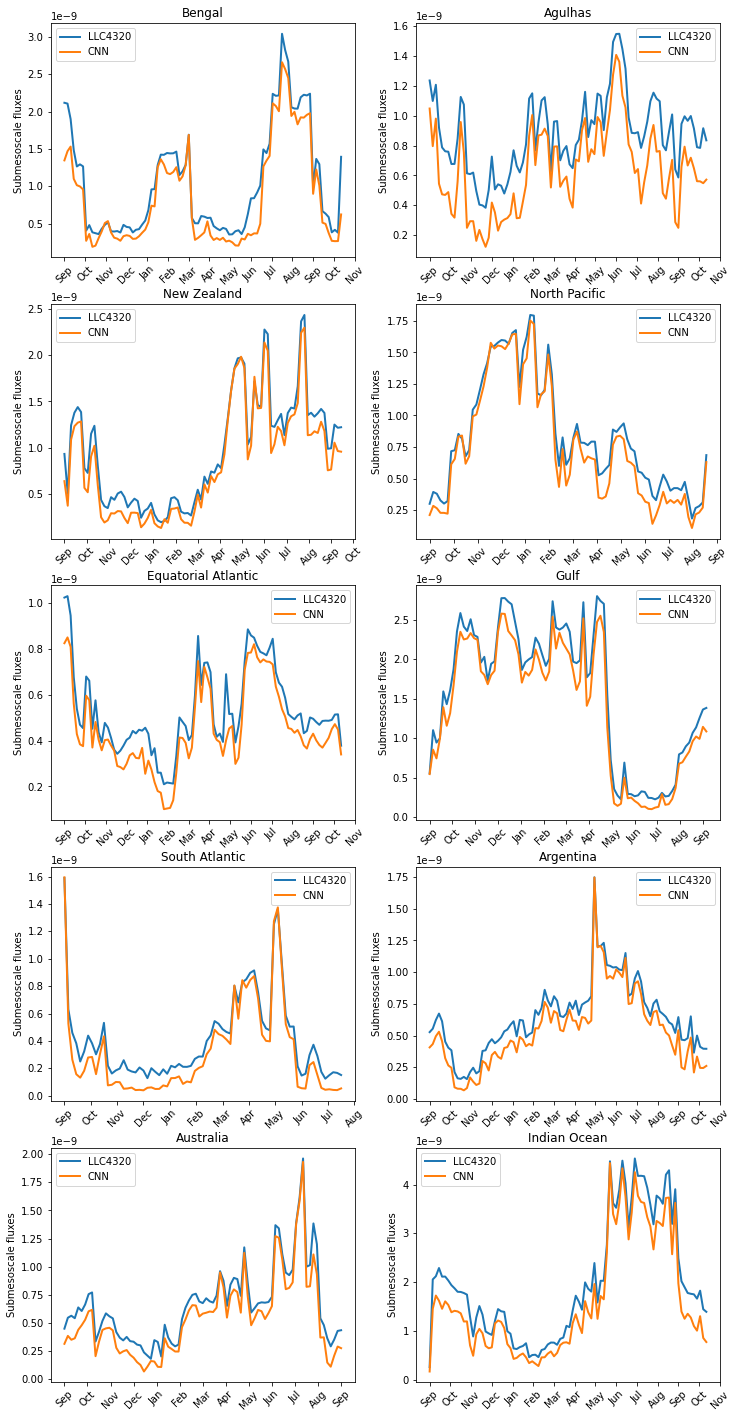

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=5,figsize=(12,25))


for i_loc in range(10):
    ax = plt.subplot(5,2,i_loc+1)
    my_xticks = ['Sep', 'Oct','Nov','Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug','Sep', 'Oct','Nov']
    plt.xticks(np.arange(0,100,100/15), my_xticks,rotation = 45);               
    WB_sg_loc_mean_plot = WB_sg_loc_mean[i_loc,~np.isnan(WB_sg_loc_mean[i_loc])]
    WB_cnn_loc_mean_plot = WB_cnn_loc_mean[i_loc,~np.isnan(WB_cnn_loc_mean[i_loc])]
    
    plt.ylabel('Submesoscale fluxes')
    plt.plot(WB_sg_loc_mean_plot,'-',linewidth=2,label='LLC4320')
    plt.plot(WB_cnn_loc_mean_plot,'-',linewidth=2,label='CNN')
    plt.title(label_list[i_loc])
    #if i_loc==0:
    plt.legend()
    #corr_loc[i_loc]
        

plt.savefig('./figures/cnn_7l_k5_surface_inputs_timeseries')


## Jacobian

In [19]:
def Jacobian_norm(x,y):
    if y.shape[1] != 1:
        print('wrong shape')
  
    dydx = torch.zeros(x.shape[1])

    grad = torch.autograd.grad(
        outputs=y, inputs=x,
        grad_outputs=torch.ones_like(y),
        allow_unused=True, retain_graph=True, create_graph=True)[0]
      
    if grad.shape != x.shape:
        print('Error in dimensions')

    return torch.mean(grad**2, dim=[-2,-1]).mean(dim=0)

In [20]:
jacobian_all = Jacobian_norm(b_x,prediction)

Text(0, 0.5, '$\\nabla_{input}\\ \\overline{wb}^z}$')

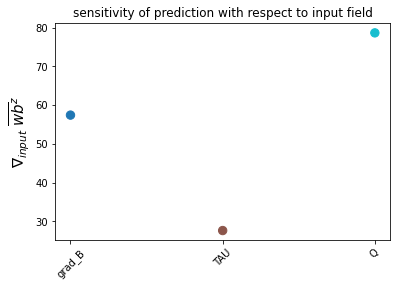

In [21]:
plt.scatter(np.arange(3),jacobian_all.detach(),c=range(3),s=70,cmap='tab10')
my_xticks = ['grad_B','TAU', 'Q']
plt.xticks(np.arange(3), my_xticks,rotation = 45);
plt.title('sensitivity of prediction with respect to input field')
plt.ylabel(r'$\nabla_{input}\ \overline{wb}^z}$',fontsize=15)

In [22]:
# Jacobian per location

jacobian_loc = np.empty((10,3))
r2score_loc = np.empty((10,1))
corr_loc = np.empty((10,1))

for i_loc in range(10):
    torch_dataset_test_loc = Data.TensorDataset(
        torch.from_numpy(X_input[test_ind[location_index[test_ind]==i_loc]]).double(),
        torch.from_numpy(Y_output[test_ind[location_index[test_ind]==i_loc]]).double(),    
    )

    BATCH_SIZE_TEST = len(torch_dataset_test_loc)

    loader_test_loc = Data.DataLoader(
        dataset=torch_dataset_test_loc, batch_size=BATCH_SIZE_TEST, shuffle=False
    )


  
    loader_test_loc
    b_x_loc, b_y_loc, prediction_loc = plot_model_direct(cnn_submeso, criterion, loader_test_loc,len(torch_dataset_test_loc))

    jacobian_loc[i_loc,:] = Jacobian_norm(b_x_loc,prediction_loc).detach().cpu().numpy()
    
    r2score_loc[i_loc] = r2_score(b_y_loc.detach().cpu().numpy().flatten(), prediction_loc.detach().cpu().numpy().flatten())
    
    corr_loc[i_loc] = stats.pearsonr(b_y_loc.detach().cpu().numpy().flatten(), prediction_loc.detach().cpu().numpy().flatten())[0]


Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.22874606619400112
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.5223853687541914
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.26347358430261986
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.29004162944071576
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.32334603365590314
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.3092042374979796
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.26613518657306556
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.30975272908397466
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.29030723592204594
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.2652597201239262


# SHAP values

In [12]:
# Define your CNN model for image-to-image mapping
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        # Define the layers of your CNN model
        
    def forward(self, x):
        # Implement the forward pass of your model
        return x.var(dim=[-1,-2])

# Generate some random image data for explanation
data = np.random.randint(0, 256, (10, 3, 256, 256), dtype=np.uint8)

# Convert the data to torch tensors and normalize
data_tensor = torch.tensor(data, dtype=torch.double).to(device)

# Create an instance of your model
model = torch.load(PATH_NN_surface+'cnn_7l_k5_surface_inputs.pth')

# Load the model weights (optional)
# model.load_state_dict(torch.load('model_weights.pth'))

# Create a DeepExplainer instance
explainer = shap.DeepExplainer(model, data_tensor)

# Choose an instance from the data for which you want to explain the predictions
instance = data_tensor[0:1]

# Generate explanations using DeepExplainer
explanations = explainer.shap_values(instance)

# Print the explanations
print(explanations)


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


[[[[ 1.42987625e-01 -1.85426053e-01  4.94598913e-01 ... -1.31794255e-01
     1.13008651e-01 -4.18609770e-01]
   [-6.89026683e-03  1.71456644e+00 -3.24624133e-01 ...  4.82647629e-01
    -2.76079481e-01  9.99318789e-02]
   [ 2.17698608e-01 -2.36494389e-01  1.05910274e+00 ...  2.70648236e-01
    -1.59856231e-01  6.56501453e-01]
   ...
   [ 8.63321155e-01  4.36476022e-01  1.28156457e+00 ... -2.31031823e-03
     3.49997362e-01 -2.25017204e-01]
   [ 8.08423520e-02 -1.33587143e+00  2.69686954e-01 ... -5.63531741e-01
     4.05020213e-01 -1.62766305e-02]
   [-1.33539161e-01  8.13134113e-02 -8.00555900e-02 ... -1.05676029e-01
    -2.16895510e-01 -9.58267442e-01]]

  [[ 6.08650320e-01  3.66871950e-01  9.87234745e-02 ... -2.20040352e-01
     1.35621983e-01 -1.10076084e-01]
   [ 5.05531313e-01  1.33523902e-02 -1.33191787e-01 ...  1.22349513e-01
     1.73646063e-02  3.93423921e-04]
   [-5.83341960e-02  1.34232721e-01 -3.46169871e-02 ... -2.17156614e-01
     5.49928796e-01 -9.89673654e-02]
   ...
   

In [29]:
# Load saved model 
model = torch.load(PATH_NN_surface+'cnn_7l_k5_surface_inputs.pth')

# Use CPU
#device_cpu = torch.device('cpu')
model = model.to(device)

In [30]:
#Load 100 images for background
torch_dataset_train = Data.TensorDataset(
    torch.from_numpy(X_input[train_ind]).double(),
    torch.from_numpy(Y_output[train_ind]).double(),
)


shap_loader = Data.DataLoader(
    dataset=torch_dataset_train, batch_size=100, shuffle=True
)


background, _ = next(iter(shap_loader))
background = background.to(device)
background.requires_grad = True

In [31]:
model.eval()

CNN_direct(
  (conv1): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1), padding=same, padding_mode=reflect)
  (conv1_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=same, padding_mode=reflect)
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 48, kernel_size=(5, 5), stride=(1, 1), padding=same, padding_mode=reflect)
  (conv3_bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(48, 32, kernel_size=(5, 5), stride=(1, 1), padding=same, padding_mode=reflect)
  (conv4_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1), padding=same, padding_mode=reflect)
  (conv5_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(16, 8, kernel

In [35]:
#Create SHAP explainer 
explainer = shap.DeepExplainer(model, background)

In [37]:
# SHAP mean values per location

l2_shap_values_mean_loc = np.empty((10,3))


for i_loc in range(10):
    torch_dataset_test_loc = Data.TensorDataset(
        torch.from_numpy(X_input[test_ind[location_index[test_ind]==i_loc]]).double(),
        torch.from_numpy(Y_output[test_ind[location_index[test_ind]==i_loc]]).double()
    )

    BATCH_SIZE_TEST = len(torch_dataset_test_loc)

    loader_test_loc = Data.DataLoader(
        dataset=torch_dataset_test_loc, batch_size=BATCH_SIZE_TEST, shuffle=False
    )
    
    test_input,_ = next(iter(loader_test_loc))
    
    shap_values = explainer.shap_values(test_input.to(device))
  
    l2_shap_values_mean_loc[i_loc,:] = np.squeeze(np.mean(np.apply_over_axes(np.sum,shap_values*shap_values,[-1,-2]),axis=0))


In [38]:
np.save(PATH_NN_surface+'l2_shap_values_mean_loc.py',l2_shap_values_mean_loc)

In [84]:
l2_shap_values_mean = np.squeeze(np.mean(np.apply_over_axes(np.sum,shap_values*shap_values,[-1,-2]),axis=0))

In [2]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,4))

plt.bar(label_list,l2_shap_values_mean_loc[:,0],label=r"$\nabla\overline{b}$")
plt.bar(label_list,l2_shap_values_mean_loc[:,1],bottom=l2_shap_values_mean_loc[:,0],label='Wind stress')
plt.bar(label_list,l2_shap_values_mean_loc[:,2],bottom=l2_shap_values_mean_loc[:,1]+l2_shap_values_mean_loc[:,0],label='Surface heat flux')
my_xticks = label_list
plt.xticks(np.arange(10), my_xticks,rotation = 45);
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.ylabel('mean SHAP values: impact on output')

plt.savefig('./figures/cnn_7l_k5_surface_inputs_SHAP_bar_locs')


NameError: name 'plt' is not defined

# locations

In [ ]:
location_test = location_index[test_ind]

# renormalize using mean and std 
WB_sg_mean_test = WB_sg_mean[test_ind]
WB_sg_std_test = WB_sg_std[test_ind] 

mean_tile = np.transpose(np.tile(WB_sg_mean_test,(40,40,1,1)))
std_tile = np.transpose(np.tile(WB_sg_std_test,(40,40,1,1)))

WB_cnn = np.squeeze((cnn_submeso(b_x.to(device)).detach().cpu().numpy()*std_tile + mean_tile))

WB_sg = np.squeeze(xr.DataArray((b_y.detach().cpu().numpy()*std_tile + mean_tile)))

WB_cnn_loc = np.empty((10,846,40,40))
WB_cnn_loc[:] = np.nan
WB_cnn_loc_flat = np.empty((10,846*40*40))

WB_sg_loc = np.empty((10,846,40,40))
WB_sg_loc[:] = np.nan
WB_sg_loc_flat = np.empty((10,846*40*40))

# renormalize to physical space

Q_mean_test_tile = np.transpose(np.tile(Q_mean[test_ind],(40,40,1)))
Q_std_test_tile = np.transpose(np.tile(Q_std[test_ind],(40,40,1)))
Q_phys = Q[test_ind]*Q_std_test_tile + Q_mean_test_tile

TAU_mean_test_tile = np.transpose(np.tile(TAU_mean[test_ind],(40,40,1)))
TAU_std_test_tile = np.transpose(np.tile(TAU_std[test_ind],(40,40,1)))
TAU_phys = TAU[test_ind]*TAU_std_test_tile + TAU_mean_test_tile

grad_B_mean_test_tile = np.transpose(np.tile(grad_B_mean[test_ind],(40,40,1)))
grad_B_std_test_tile = np.transpose(np.tile(grad_B_std[test_ind],(40,40,1)))
grad_B_phys = grad_B[test_ind]*grad_B_std_test_tile + grad_B_mean_test_tile

Q_loc = np.empty((10,846,40,40))
TAU_loc = np.empty((10,846,40,40))
grad_B_loc = np.empty((10,846,40,40))

WB_sg_loc_mean = np.empty((10,1))
WB_cnn_loc_mean = np.empty((10,1))
Q_loc_mean = np.empty((10,1))
TAU_loc_mean = np.empty((10,1))
grad_B_loc_mean = np.empty((10,1))
i_max_loc = np.empty((10,1))

# cell size 
drF_test = drF[test_ind] 
drF_test_loc = np.empty((10,846,40,40))
drF_test_loc[:] = np.nan

for i_loc in range(10):
    drF_test_loc[i_loc,location_index[test_ind]==i_loc,:,:] = drF_test[location_index[test_ind]==i_loc]
    
    WB_cnn_loc[i_loc,location_index[test_ind]==i_loc,:,:] = WB_cnn[location_index[test_ind]==i_loc]
    WB_cnn_loc_flat[i_loc,:]  = WB_cnn_loc[i_loc].flatten()
    WB_cnn_loc_mean[i_loc] = np.nanmax((np.squeeze(np.apply_over_axes(np.sum, WB_cnn_loc[i_loc]*WB_cnn_loc[i_loc]*drF_test_loc[i_loc], [1,2])) / np.nansum(drF_test_loc[i_loc]))**0.5)
    i_max_loc[i_loc] = np.argmax((np.squeeze(np.apply_over_axes(np.nansum, WB_cnn_loc[i_loc]*WB_cnn_loc[i_loc]*drF_test_loc[i_loc], [1,2])) / np.nansum(drF_test_loc[i_loc]))**0.5)

    
    WB_sg_loc[i_loc,location_index[test_ind]==i_loc,:,:] = WB_sg[location_index[test_ind]==i_loc]
    WB_sg_loc_flat[i_loc,:]  = WB_sg_loc[i_loc].flatten()
    WB_sg_loc_mean[i_loc] = ((np.squeeze(np.apply_over_axes(np.sum, WB_sg_loc[i_loc]*WB_sg_loc[i_loc]*drF_test_loc[i_loc], [1,2])) / np.nansum(drF_test_loc[i_loc]))**0.5)[int(i_max_loc[i_loc])]
    
    
    Q_loc[i_loc,location_index[test_ind]==i_loc,:,:] = Q_phys[location_index[test_ind]==i_loc]
    Q_loc_mean[i_loc] = ((np.squeeze(np.apply_over_axes(np.sum, Q_loc[i_loc]*Q_loc[i_loc]*drF_test_loc[i_loc], [1,2])) / np.nansum(drF_test_loc[i_loc]))**0.5)[int(i_max_loc[i_loc])]
    
    TAU_loc[i_loc,location_index[test_ind]==i_loc,:,:] = TAU_phys[location_index[test_ind]==i_loc]
    TAU_loc_mean[i_loc] = ((np.squeeze(np.apply_over_axes(np.sum, TAU_loc[i_loc]*TAU_loc[i_loc]*drF_test_loc[i_loc], [1,2])) / np.nansum(drF_test_loc[i_loc]))**0.5)[int(i_max_loc[i_loc])]
    
    grad_B_loc[i_loc,location_index[test_ind]==i_loc,:,:] = grad_B_phys[location_index[test_ind]==i_loc]
    grad_B_loc_mean[i_loc] = ((np.squeeze(np.apply_over_axes(np.sum, grad_B_loc[i_loc]*grad_B_loc[i_loc]*drF_test_loc[i_loc], [1,2])) / np.nansum(drF_test_loc[i_loc]))**0.5)[int(i_max_loc[i_loc])]
    

## magnitude

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(8,12))
fig.set_tight_layout(True)

ax = plt.subplot(3,1,1)
from matplotlib.pyplot import cm
cmap='tab10'
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    plt.scatter(Q_loc_mean[i_loc],WB_cnn_loc_mean[i_loc],color=c_loc,s=100+3*jacobian_loc[i_loc,0],marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(Q_loc_mean[i_loc],WB_cnn_loc_mean[i_loc],color='k',s=10,marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(Q_loc_mean[i_loc]*np.nan, WB_sg_loc_mean[i_loc],color=c_loc,s=100,marker='o',alpha=0.5)
    plt.legend(label_list,bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #ax.set_yscale('log')
    #ax.set_xscale('log')
plt.ylabel('WB cnn mag')
plt.xlabel('Q mag')
    
ax = plt.subplot(3,1,2)
from matplotlib.pyplot import cm
cmap='tab10'
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    plt.scatter(TAU_loc_mean[i_loc],WB_cnn_loc_mean[i_loc],color=c_loc,s=100+3*jacobian_loc[i_loc,1],marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(TAU_loc_mean[i_loc],WB_cnn_loc_mean[i_loc],color='k',s=10,marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(TAU_loc_mean[i_loc]*np.nan,WB_sg_loc_mean[i_loc],color=c_loc,s=100,marker='o',alpha=0.5)
    plt.legend(label_list,bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #ax.set_yscale('log')
    #ax.set_xscale('log')
plt.ylabel('WB cnn mag')
plt.xlabel('TAU mag')

ax = plt.subplot(3,1,3)
from matplotlib.pyplot import cm
cmap='tab10'
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    plt.scatter(grad_B_loc_mean[i_loc],WB_cnn_loc_mean[i_loc],color=c_loc,s=100+3*jacobian_loc[i_loc,2],marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(grad_B_loc_mean[i_loc],WB_cnn_loc_mean[i_loc],color='k',s=10,marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(grad_B_loc_mean[i_loc]*np.nan,WB_sg_loc_mean[i_loc],color=c_loc,s=100,marker='o',alpha=0.5)
    plt.legend(label_list,bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #ax.set_yscale('log')
    #ax.set_xscale('log')
plt.ylabel('WB cnn mag')
plt.xlabel('grad B mag')

plt.savefig('./figures/cnn_7l_k5_surface_inputs_magnitude_Jacobian')


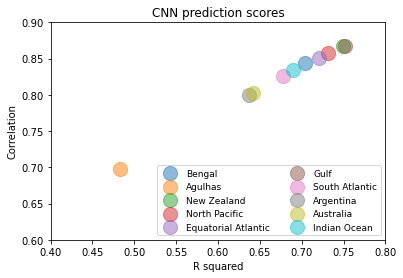

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(6,4))

from matplotlib.pyplot import cm
cmap='tab10'
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    plt.scatter(r2score_loc[i_loc],corr_loc[i_loc],color=c_loc,s=200,alpha=0.5)
    plt.xlim([0.4,.8])
    plt.ylim([0.6,.9])
    #plt.legend(label_list)
    plt.legend(label_list,ncol=2,loc='lower right', fontsize=9)
plt.xlabel('R squared')
plt.ylabel('Correlation')
plt.title('CNN prediction scores')
plt.savefig('./figures/cnn_7l_k5_surface_inputs_R2_corr_scores')

In [ ]:
r2score_loc

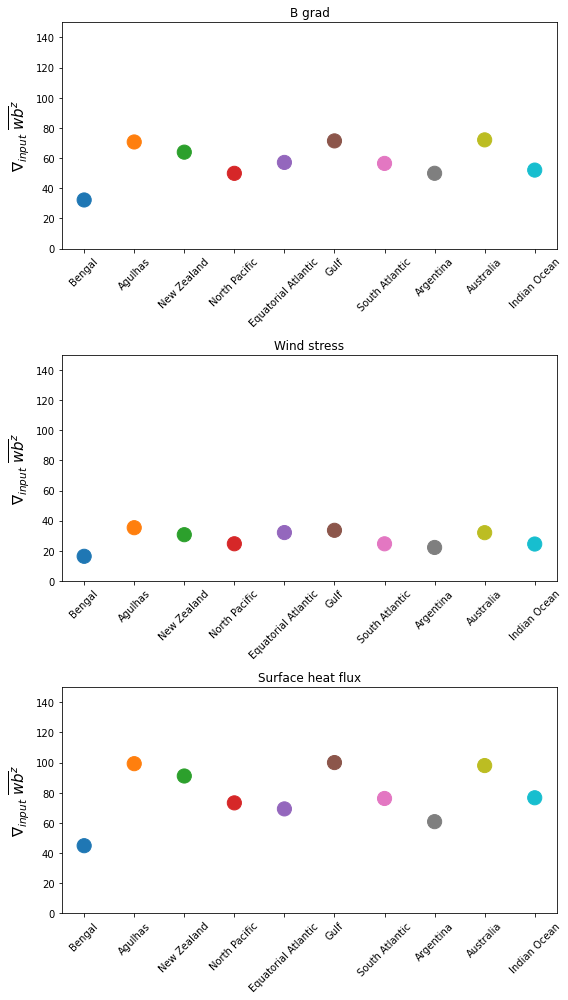

In [31]:
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(8,14))
fig.set_tight_layout(True)

ax = plt.subplot(3,1,1)
plt.scatter(np.arange(10),jacobian_loc[:,0],c=range(10),s=200,cmap='tab10')
my_xticks = label_list
plt.xticks(np.arange(10), my_xticks,rotation = 45);
plt.title('B grad')
plt.ylim([0,150])
plt.ylabel(r'$\nabla_{input}\ \overline{wb}^z}$',fontsize=15)

ax = plt.subplot(3,1,2)
plt.scatter(np.arange(10),jacobian_loc[:,1],c=range(10),s=200,cmap='tab10')
my_xticks = label_list
plt.xticks(np.arange(10), my_xticks,rotation = 45);
plt.title('Wind stress')
plt.ylim([0,150])
plt.ylabel(r'$\nabla_{input}\ \overline{wb}^z}$',fontsize=15)

ax = plt.subplot(3,1,3)
plt.scatter(np.arange(10),jacobian_loc[:,2],c=range(10),s=200,cmap='tab10')
my_xticks = label_list
plt.xticks(np.arange(10), my_xticks,rotation = 45);
plt.title('Surface heat flux')
plt.ylabel(r'$\nabla_{input}\ \overline{wb}^z}$',fontsize=15)
plt.ylim([0,150])
plt.savefig('./figures/cnn_7l_k5_surface_inputs_Jacobian')

# Regional statistics

## positive fluxes

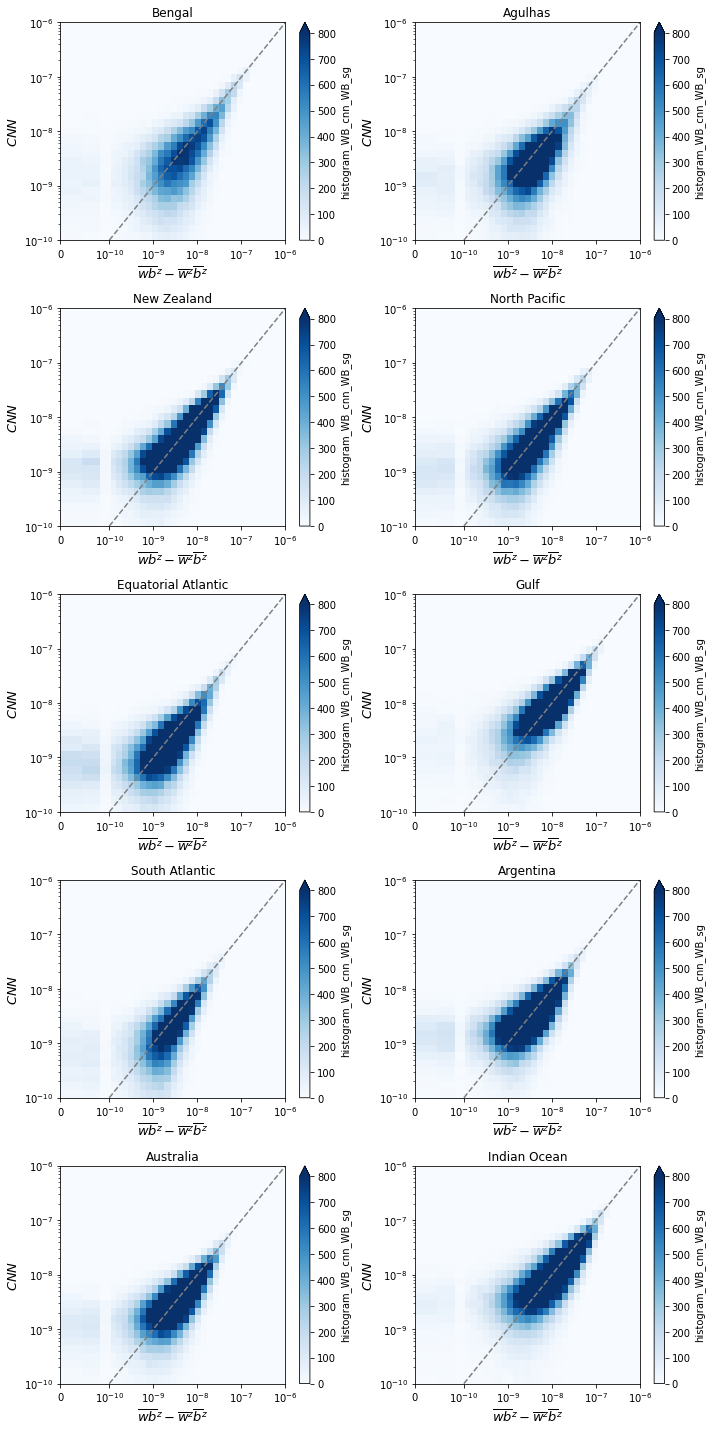

In [32]:
import matplotlib as mpl
from xhistogram.xarray import histogram as xhist

fig, axes = plt.subplots(nrows=5, ncols=2,figsize=(10,20))
fig.set_tight_layout(True)

i_plot=0

for i_loc in range(10):
    
    WB_cnn  = xr.DataArray(WB_cnn_loc_flat[i_loc,:])
    WB_cnn.name = 'WB_cnn'
    WB_sg  = xr.DataArray(WB_sg_loc_flat[i_loc,:])
    WB_sg.name = 'WB_sg'

    xhist_CNN = xhist(WB_cnn, 
      WB_sg,
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),
                                            np.logspace(-10,-6,30)))))
           ]
     ).compute()
    

    ax = plt.subplot(5,2,i_loc+1)
    xhist_CNN.plot(vmax=800, cmap='Blues')
    ax.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
    ax.set_xscale('symlog', linthresh=1e-10)
    ax.set_yscale('log')
    ax.set_ylim([1e-10,1e-6])
    ax.set_xlim([0,1e-6])
    ax.set_xlabel(r"$\overline{wb}^z-\overline{w}^z\overline{b}^z$", fontsize=13)
    ax.set_ylabel(r"$CNN$", 
                  fontsize=13)
    plt.title(label_list[i_loc])


plt.savefig('./figures/cnn_7l_k5_surface_inputs_all_positive_fluxes')

## negative fluxes

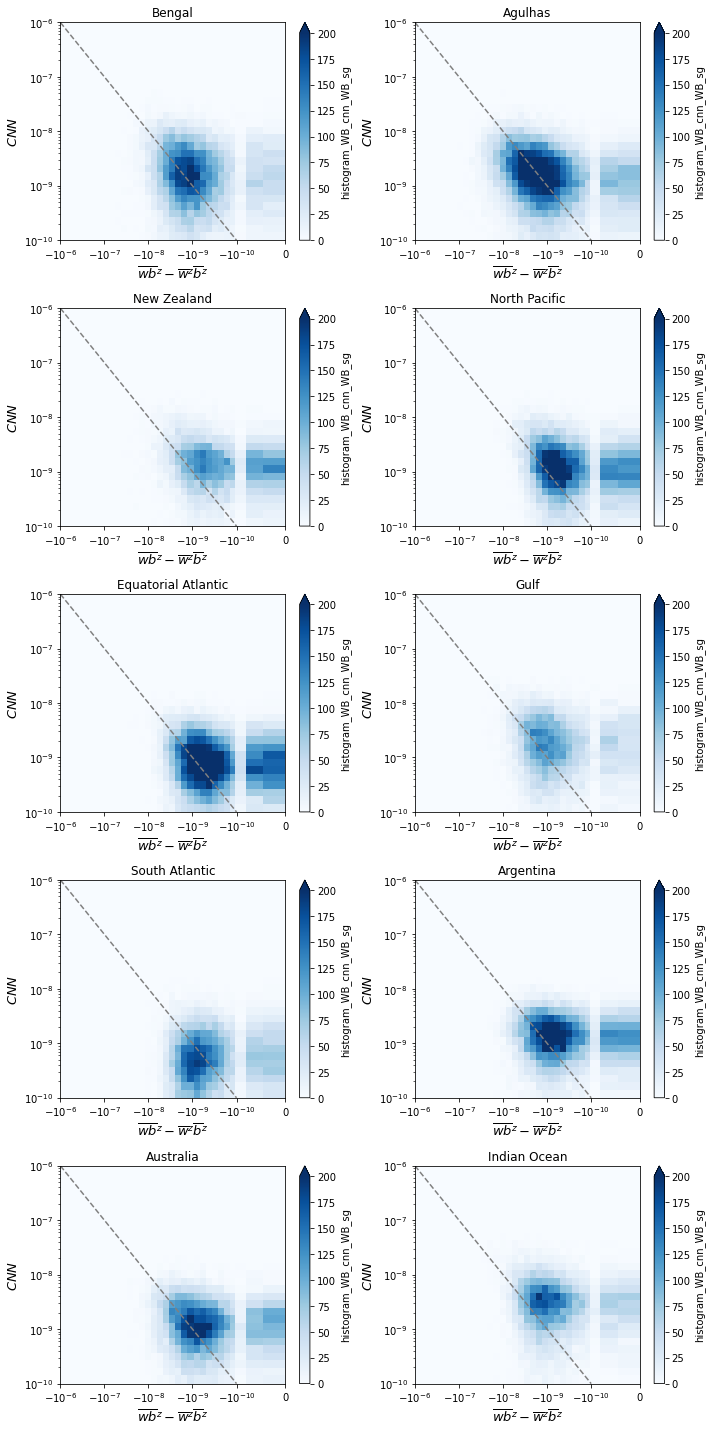

In [33]:
import matplotlib as mpl
from xhistogram.xarray import histogram as xhist

fig, axes = plt.subplots(nrows=5, ncols=2,figsize=(10,20))
fig.set_tight_layout(True)

i_plot=0

for i_loc in range(10):
    
    WB_cnn  = xr.DataArray(WB_cnn_loc_flat[i_loc,:])
    WB_cnn.name = 'WB_cnn'
    WB_sg  = xr.DataArray(WB_sg_loc_flat[i_loc,:])
    WB_sg.name = 'WB_sg'

    xhist_CNN = xhist(WB_cnn, 
      WB_sg,
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),
                                            np.logspace(-10,-6,30)))))
           ]
     ).compute()
    ax = plt.subplot(5,2,i_loc+1)
    xhist_CNN.plot(vmax=200, cmap='Blues')
    ax.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
    ax.set_xscale('symlog', linthresh=1e-10)
    ax.set_yscale('log')
    ax.set_ylim([1e-10,1e-6])
    ax.set_xlim([-1e-6,0])
    ax.set_xlabel(r"$\overline{wb}^z-\overline{w}^z\overline{b}^z$", fontsize=13)
    ax.set_ylabel(r"$CNN$", 
                  fontsize=13)
    plt.title(label_list[i_loc])


plt.savefig('./figures/cnn_7l_k5_surface_inputs_all_negative_fluxes')

# Seasonality - JFM


In [34]:
# build test loader for JFM and JAS
b_x_JFM, b_y_JFM, prediction_JFM = plot_model_direct(cnn_submeso, criterion, loader_test_JFM,len(torch_dataset_test_JFM))

Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.26056235255185894


In [35]:
jacobian_JFM = Jacobian_norm(b_x,prediction)

Text(0, 0.5, '$\\nabla_{input}\\ \\overline{wb}^z}$')

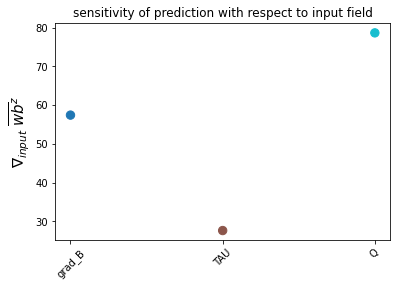

In [36]:
plt.scatter(np.arange(3),jacobian_JFM.detach(),c=range(3),s=70,cmap='tab10')
my_xticks = ['grad_B','TAU', 'Q']
plt.xticks(np.arange(3), my_xticks,rotation = 45);
plt.title('sensitivity of prediction with respect to input field')
plt.ylabel(r'$\nabla_{input}\ \overline{wb}^z}$',fontsize=15)

In [76]:
# renormalize using mean and std 
WB_sg_mean_test = WB_sg_mean[JFM_test_ind]
WB_sg_std_test = WB_sg_std[JFM_test_ind] 

mean_tile = np.transpose(np.tile(WB_sg_mean_test,(40,40,1,1)))
std_tile = np.transpose(np.tile(WB_sg_std_test,(40,40,1,1)))

WB_cnn_JFM = np.squeeze((cnn_submeso(b_x_JFM.to(device)).detach().cpu().numpy()*std_tile + mean_tile))

WB_sg_JFM = np.squeeze(xr.DataArray((b_y_JFM.detach().cpu().numpy()*std_tile + mean_tile)))

WB_cnn_loc = np.empty((10,len(JFM_test_ind),40,40))
WB_cnn_loc[:] = np.nan
WB_cnn_loc_flat = np.empty((10,len(JFM_test_ind)*40*40))

WB_sg_loc = np.empty((10,len(JFM_test_ind),40,40))
WB_sg_loc[:] = np.nan
WB_sg_loc_flat = np.empty((10,len(JFM_test_ind)*40*40))

# renormalize to physical space

Q_mean_test_tile = np.transpose(np.tile(Q_mean[JFM_test_ind],(40,40,1)))
Q_std_test_tile = np.transpose(np.tile(Q_std[JFM_test_ind],(40,40,1)))
Q_phys = Q[JFM_test_ind]*Q_std_test_tile + Q_mean_test_tile

TAU_mean_test_tile = np.transpose(np.tile(TAU_mean[JFM_test_ind],(40,40,1)))
TAU_std_test_tile = np.transpose(np.tile(TAU_std[JFM_test_ind],(40,40,1)))
TAU_phys = TAU[JFM_test_ind]*TAU_std_test_tile + TAU_mean_test_tile

grad_B_mean_test_tile = np.transpose(np.tile(grad_B_mean[JFM_test_ind],(40,40,1)))
grad_B_std_test_tile = np.transpose(np.tile(grad_B_std[JFM_test_ind],(40,40,1)))
grad_B_phys = grad_B[JFM_test_ind]*grad_B_std_test_tile + grad_B_mean_test_tile

Q_loc = np.empty((10,len(JFM_test_ind),40,40))
TAU_loc = np.empty((10,len(JFM_test_ind),40,40))
grad_B_loc = np.empty((10,len(JFM_test_ind),40,40))

WB_sg_loc_mean_JFM = np.empty((10,1))
WB_cnn_loc_mean_JFM = np.empty((10,1))
Q_loc_mean_JFM = np.empty((10,1))
TAU_loc_mean_JFM = np.empty((10,1))
grad_B_loc_mean_JFM = np.empty((10,1))
i_max_loc = np.empty((10,1))

# cell size 
drF_test_JFM = drF[JFM_test_ind] 
drF_test_loc = np.empty((10,len(JFM_test_ind),40,40))
drF_test_loc[:] = np.nan

for i_loc in range(10):
    drF_test_loc[i_loc,location_index[JFM_test_ind]==i_loc,:,:] = drF_test_JFM[location_index[JFM_test_ind]==i_loc]
    
    WB_cnn_loc[i_loc,location_index[JFM_test_ind]==i_loc,:,:] = WB_cnn_JFM[location_index[JFM_test_ind]==i_loc]
    WB_cnn_loc_flat[i_loc,:]  = WB_cnn_loc[i_loc].flatten()
    WB_cnn_loc_mean_JFM[i_loc] =  np.nanmax((np.squeeze(np.apply_over_axes(np.nansum, WB_cnn_loc[i_loc]*WB_cnn_loc[i_loc]*drF_test_loc[i_loc], [1,2])) / np.nansum(drF_test_loc[i_loc]))**0.5)
    i_max_loc[i_loc] = np.argmax((np.squeeze(np.apply_over_axes(np.nansum, WB_cnn_loc[i_loc]*WB_cnn_loc[i_loc]*drF_test_loc[i_loc], [1,2])) / np.nansum(drF_test_loc[i_loc]))**0.5)
    
    WB_sg_loc[i_loc,location_index[JFM_test_ind]==i_loc,:,:] = WB_sg_JFM[location_index[JFM_test_ind]==i_loc]
    WB_sg_loc_flat[i_loc,:]  = WB_sg_loc[i_loc].flatten()
    WB_sg_loc_mean_JFM[i_loc] =  ((np.squeeze(np.apply_over_axes(np.nansum, WB_sg_loc[i_loc]*WB_sg_loc[i_loc]*drF_test_loc[i_loc], [1,2])) / np.nansum(drF_test_loc[i_loc]))**0.5)[int(i_max_loc[i_loc])]
    
    Q_loc[i_loc,location_index[JFM_test_ind]==i_loc,:,:] = Q_phys[location_index[JFM_test_ind]==i_loc]
    Q_loc_mean_JFM[i_loc] =((np.squeeze(np.apply_over_axes(np.nansum, Q_loc[i_loc]*Q_loc[i_loc]*drF_test_loc[i_loc], [1,2])) / np.nansum(drF_test_loc[i_loc]))**0.5)[int(i_max_loc[i_loc])]
    
    TAU_loc[i_loc,location_index[JFM_test_ind]==i_loc,:,:] = TAU_phys[location_index[JFM_test_ind]==i_loc]
    TAU_loc_mean_JFM[i_loc] = ((np.squeeze(np.apply_over_axes(np.nansum, TAU_loc[i_loc]*TAU_loc[i_loc]*drF_test_loc[i_loc], [1,2])) / np.nansum(drF_test_loc[i_loc]))**0.5)[int(i_max_loc[i_loc])]
    
    grad_B_loc[i_loc,location_index[JFM_test_ind]==i_loc,:,:] = grad_B_phys[location_index[JFM_test_ind]==i_loc]
    grad_B_loc_mean_JFM[i_loc] = ((np.squeeze(np.apply_over_axes(np.nansum, grad_B_loc[i_loc]*grad_B_loc[i_loc]*drF_test_loc[i_loc], [1,2])) / np.nansum(drF_test_loc[i_loc]))**0.5)[int(i_max_loc[i_loc])]


In [38]:
# Jacobian per location JFM


r2score_loc_JFM = np.empty((10,1))
corr_loc_JFM = np.empty((10,1))
jacobian_loc_JFM = np.empty((10,3))

for i_loc in range(10):
    torch_dataset_test_loc = Data.TensorDataset(
        torch.from_numpy(X_input[JFM_test_ind[location_index[JFM_test_ind]==i_loc]]).double(),
        torch.from_numpy(Y_output[JFM_test_ind[location_index[JFM_test_ind]==i_loc]]).double(),    
    )

    BATCH_SIZE_TEST = len(torch_dataset_test_loc)

    loader_test_loc = Data.DataLoader(
        dataset=torch_dataset_test_loc, batch_size=BATCH_SIZE_TEST, shuffle=False
    )


    loader_test_loc
    b_x_loc, b_y_loc, prediction_loc = plot_model_direct(cnn_submeso, criterion, loader_test_loc,len(torch_dataset_test_loc))

    jacobian_loc_JFM[i_loc,:] = Jacobian_norm(b_x_loc,prediction_loc).detach().cpu().numpy()

    r2score_loc_JFM[i_loc] = r2_score(b_y_loc.detach().cpu().numpy().flatten(), prediction_loc.detach().cpu().numpy().flatten())
    
    corr_loc_JFM[i_loc] = stats.pearsonr(b_y_loc.detach().cpu().numpy().flatten(), prediction_loc.detach().cpu().numpy().flatten())[0]


Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.187654618980096
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.37624020096314126
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.06949548756829461
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.5320115131712793
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.26629770480168596
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.4108475594892027
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.1472853009636914
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.3102780543230475
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.12587008601084335
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.07644744621786297


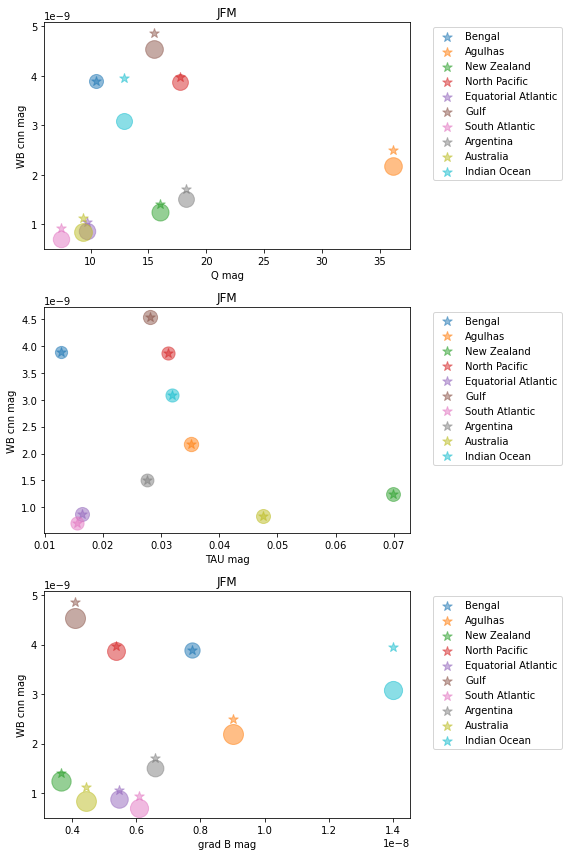

In [39]:
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(8,12))
fig.set_tight_layout(True)

ax = plt.subplot(3,1,1)
from matplotlib.pyplot import cm
cmap='tab10'
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    plt.scatter(Q_loc_mean_JFM[i_loc],WB_cnn_loc_mean_JFM[i_loc],color=c_loc,s=100+3*jacobian_loc[i_loc,0],marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(Q_loc_mean_JFM[i_loc], WB_sg_loc_mean_JFM[i_loc],color=c_loc,s=100,marker='*',alpha=0.5)
    plt.legend(label_list,bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #ax.set_yscale('log')
    #ax.set_xscale('log')
plt.ylabel('WB cnn mag')
plt.xlabel('Q mag')
plt.title('JFM')
    
ax = plt.subplot(3,1,2)
from matplotlib.pyplot import cm
cmap='tab10'
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    plt.scatter(TAU_loc_mean_JFM[i_loc],WB_cnn_loc_mean_JFM[i_loc],color=c_loc,s=100+3*jacobian_loc[i_loc,1],marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(TAU_loc_mean_JFM[i_loc],WB_cnn_loc_mean_JFM[i_loc],color=c_loc,s=100,marker='*',alpha=0.5)
    plt.legend(label_list,bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #ax.set_yscale('log')
    #ax.set_xscale('log')
plt.ylabel('WB cnn mag')
plt.xlabel('TAU mag')
plt.title('JFM')

ax = plt.subplot(3,1,3)
from matplotlib.pyplot import cm
cmap='tab10'
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    plt.scatter(grad_B_loc_mean_JFM[i_loc],WB_cnn_loc_mean_JFM[i_loc],color=c_loc,s=100+3*jacobian_loc[i_loc,2],marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(grad_B_loc_mean_JFM[i_loc],WB_sg_loc_mean_JFM[i_loc],color=c_loc,s=100,marker='*',alpha=0.5)
    plt.legend(label_list,bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #ax.set_yscale('log')
    #ax.set_xscale('log')
plt.ylabel('WB cnn mag')
plt.xlabel('grad B mag')
plt.title('JFM')

plt.savefig('./figures/cnn_7l_k5_surface_inputs_magnitude_Jacobian_JFM')


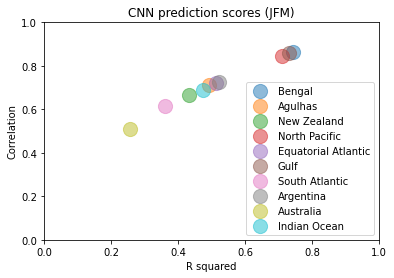

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(6,4))

from matplotlib.pyplot import cm
cmap='tab10'
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    plt.scatter(r2score_loc_JFM[i_loc],corr_loc_JFM[i_loc],color=c_loc,s=200,alpha=0.5)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.legend(label_list)
plt.xlabel('R squared')
plt.ylabel('Correlation')
plt.title('CNN prediction scores (JFM)')
plt.savefig('./figures/cnn_7l_k5_surface_inputs_R2_corr_scores_JFM')

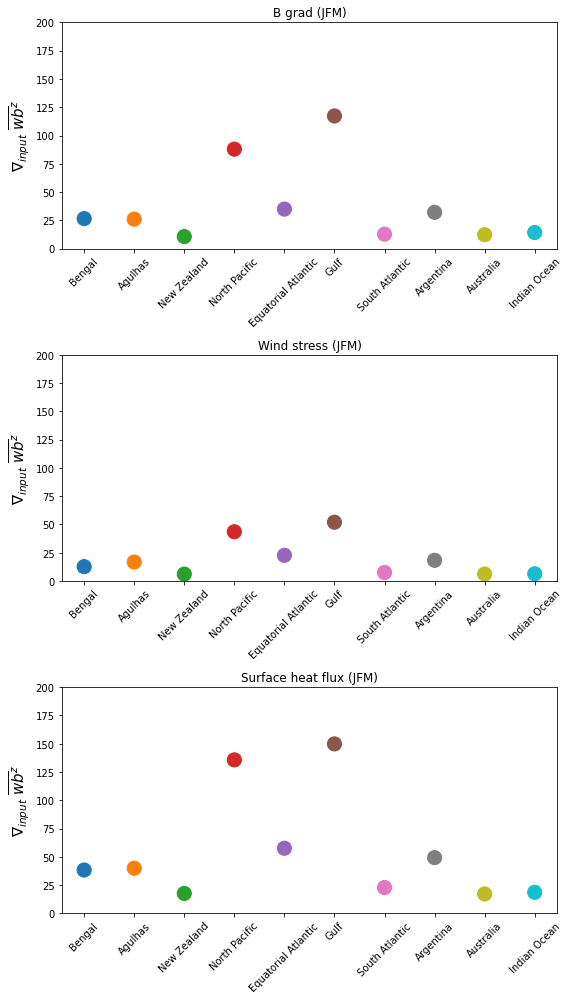

In [41]:
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(8,14))
fig.set_tight_layout(True)

ax = plt.subplot(3,1,1)
plt.scatter(np.arange(10),jacobian_loc_JFM[:,0],c=range(10),s=200,cmap='tab10')
my_xticks = label_list
plt.xticks(np.arange(10), my_xticks,rotation = 45);
plt.title('B grad (JFM)')
plt.ylim([0,200])
plt.ylabel(r'$\nabla_{input}\ \overline{wb}^z}$',fontsize=15)

ax = plt.subplot(3,1,2)
plt.scatter(np.arange(10),jacobian_loc_JFM[:,1],c=range(10),s=200,cmap='tab10')
my_xticks = label_list
plt.xticks(np.arange(10), my_xticks,rotation = 45);
plt.title('Wind stress (JFM)')
plt.ylim([0,200])
plt.ylabel(r'$\nabla_{input}\ \overline{wb}^z}$',fontsize=15)

ax = plt.subplot(3,1,3)
plt.scatter(np.arange(10),jacobian_loc_JFM[:,2],c=range(10),s=200,cmap='tab10')
my_xticks = label_list
plt.xticks(np.arange(10), my_xticks,rotation = 45);
plt.title('Surface heat flux (JFM)',fontsize=12)
plt.ylabel(r'$\nabla_{input}\ \overline{wb}^z}$',fontsize=15)
plt.ylim([0,200])
plt.savefig('./figures/cnn_7l_k5_surface_inputs_Jacobian_JFM')

## positive fluxes

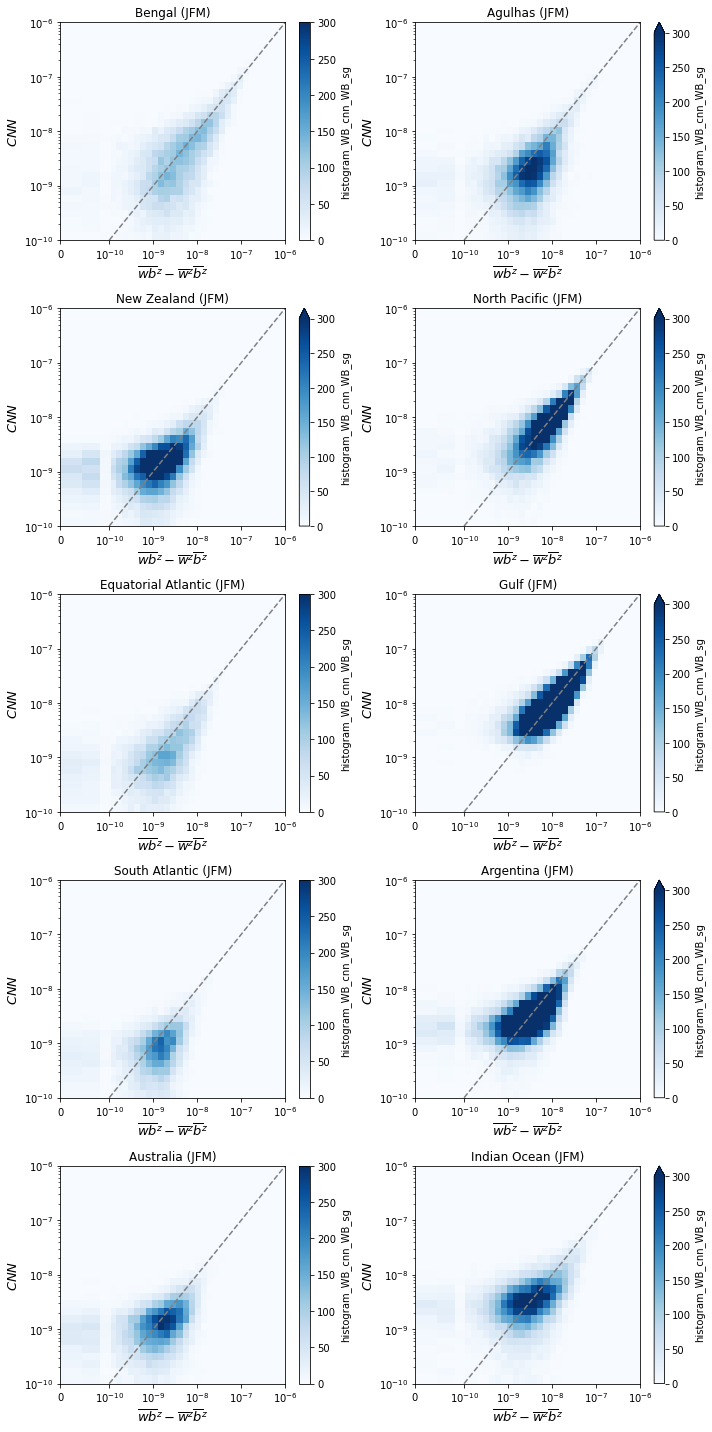

In [42]:
import matplotlib as mpl
from xhistogram.xarray import histogram as xhist

fig, axes = plt.subplots(nrows=5, ncols=2,figsize=(10,20))
fig.set_tight_layout(True)

i_plot=0

for i_loc in range(10):
    
    WB_cnn  = xr.DataArray(WB_cnn_loc_flat[i_loc,:])
    WB_cnn.name = 'WB_cnn'
    WB_sg  = xr.DataArray(WB_sg_loc_flat[i_loc,:])
    WB_sg.name = 'WB_sg'

    xhist_CNN = xhist(WB_cnn, 
      WB_sg,
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),
                                            np.logspace(-10,-6,30)))))
           ]
     ).compute()
    
    ax = plt.subplot(5,2,i_loc+1)
    xhist_CNN.plot(vmax=300, cmap='Blues')
    ax.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
    ax.set_xscale('symlog', linthresh=1e-10)
    ax.set_yscale('log')
    ax.set_ylim([1e-10,1e-6])
    ax.set_xlim([0,1e-6])
    ax.set_xlabel(r"$\overline{wb}^z-\overline{w}^z\overline{b}^z$", fontsize=13)
    ax.set_ylabel(r"$CNN$", 
                  fontsize=13)
    plt.title(label_list[i_loc]+' (JFM)')


plt.savefig('./figures/cnn_7l_k5_surface_inputs_all_positive_fluxes_seasonality_JFM')

## negative fluxes

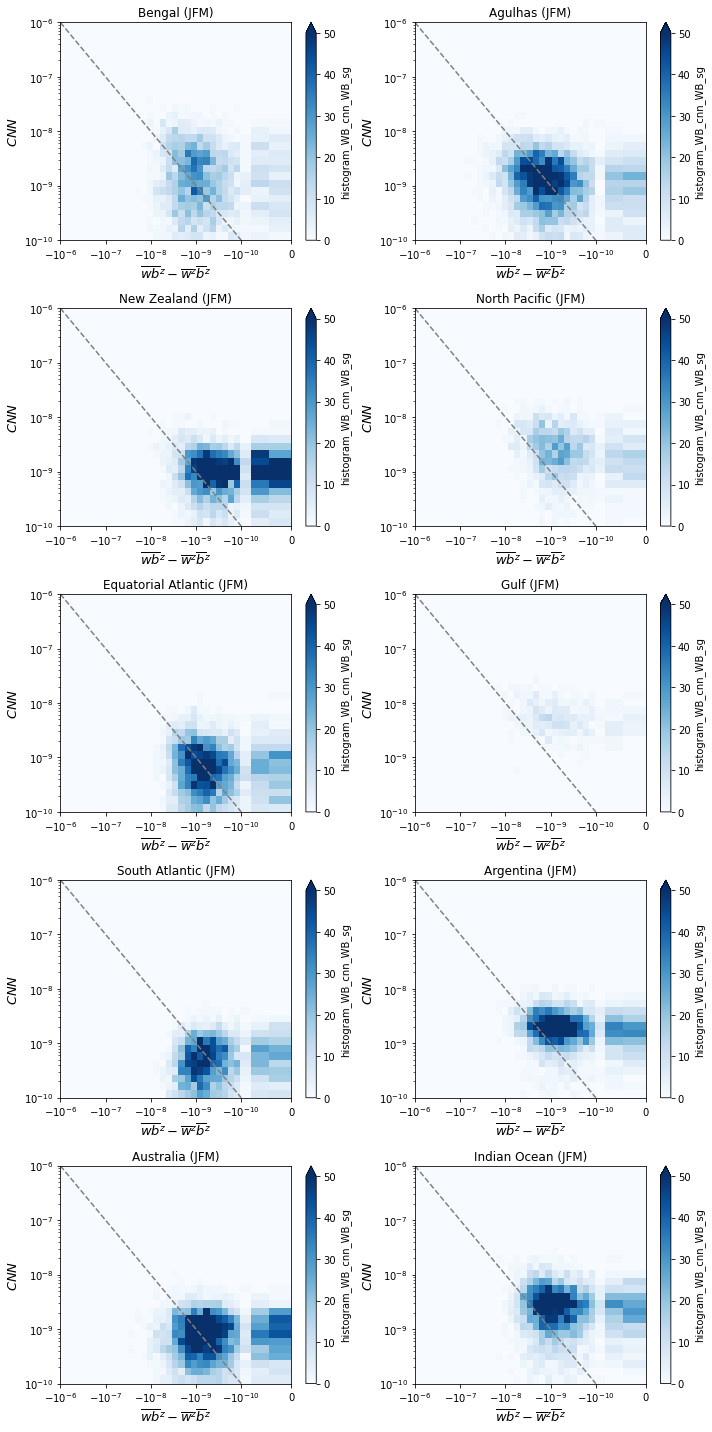

In [43]:
import matplotlib as mpl
from xhistogram.xarray import histogram as xhist

fig, axes = plt.subplots(nrows=5, ncols=2,figsize=(10,20))
fig.set_tight_layout(True)

i_plot=0

for i_loc in range(10):
    
    WB_cnn  = xr.DataArray(WB_cnn_loc_flat[i_loc,:])
    WB_cnn.name = 'WB_cnn'
    WB_sg  = xr.DataArray(WB_sg_loc_flat[i_loc,:])
    WB_sg.name = 'WB_sg'

    xhist_CNN = xhist(WB_cnn, 
      WB_sg,
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),
                                            np.logspace(-10,-6,30)))))
           ]
     ).compute()
    ax = plt.subplot(5,2,i_loc+1)
    xhist_CNN.plot(vmax=50, cmap='Blues')
    ax.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
    ax.set_xscale('symlog', linthresh=1e-10)
    ax.set_yscale('log')
    ax.set_ylim([1e-10,1e-6])
    ax.set_xlim([-1e-6,0])
    ax.set_xlabel(r"$\overline{wb}^z-\overline{w}^z\overline{b}^z$", fontsize=13)
    ax.set_ylabel(r"$CNN$", 
                  fontsize=13)
    plt.title(label_list[i_loc]+' (JFM)')


plt.savefig('./figures/cnn_7l_k5_surface_inputs_all_negative_fluxes_seasonality_JFM')

# Seasonality - JAS


In [44]:
# build test loader for JFM and JAS
b_x_JAS, b_y_JAS, prediction_JAS = plot_model_direct(cnn_submeso, criterion, loader_test_JAS,len(torch_dataset_test_JAS))

Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.40867813238059375


In [45]:
jacobian_JAS = Jacobian_norm(b_x,prediction)

Text(0, 0.5, '$\\nabla_{input}\\ \\overline{wb}^z}$')

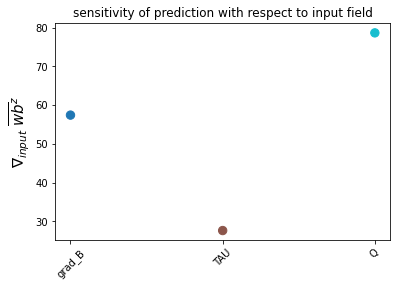

In [46]:
plt.scatter(np.arange(3),jacobian_JAS.detach(),c=range(3),s=70,cmap='tab10')
my_xticks = ['grad_B','TAU', 'Q']
plt.xticks(np.arange(3), my_xticks,rotation = 45);
plt.title('sensitivity of prediction with respect to input field')
plt.ylabel(r'$\nabla_{input}\ \overline{wb}^z}$',fontsize=15)

In [78]:
# renormalize using mean and std 
WB_sg_mean_test = WB_sg_mean[JAS_test_ind]
WB_sg_std_test = WB_sg_std[JAS_test_ind] 

mean_tile = np.transpose(np.tile(WB_sg_mean_test,(40,40,1,1)))
std_tile = np.transpose(np.tile(WB_sg_std_test,(40,40,1,1)))

WB_cnn_JAS = np.squeeze((cnn_submeso(b_x_JAS.to(device)).detach().cpu().numpy()*std_tile + mean_tile))

WB_sg_JAS = np.squeeze(xr.DataArray((b_y_JAS.detach().cpu().numpy()*std_tile + mean_tile)))

WB_cnn_loc = np.empty((10,len(JAS_test_ind),40,40))
WB_cnn_loc[:] = np.nan
WB_cnn_loc_flat = np.empty((10,len(JAS_test_ind)*40*40))

WB_sg_loc = np.empty((10,len(JAS_test_ind),40,40))
WB_sg_loc[:] = np.nan
WB_sg_loc_flat = np.empty((10,len(JAS_test_ind)*40*40))

# renormalize to physical space

Q_mean_test_tile = np.transpose(np.tile(Q_mean[JAS_test_ind],(40,40,1)))
Q_std_test_tile = np.transpose(np.tile(Q_std[JAS_test_ind],(40,40,1)))
Q_phys = Q[JAS_test_ind]*Q_std_test_tile + Q_mean_test_tile

TAU_mean_test_tile = np.transpose(np.tile(TAU_mean[JAS_test_ind],(40,40,1)))
TAU_std_test_tile = np.transpose(np.tile(TAU_std[JAS_test_ind],(40,40,1)))
TAU_phys = TAU[JAS_test_ind]*TAU_std_test_tile + TAU_mean_test_tile

grad_B_mean_test_tile = np.transpose(np.tile(grad_B_mean[JAS_test_ind],(40,40,1)))
grad_B_std_test_tile = np.transpose(np.tile(grad_B_std[JAS_test_ind],(40,40,1)))
grad_B_phys = grad_B[JAS_test_ind]*grad_B_std_test_tile + grad_B_mean_test_tile

Q_loc = np.empty((10,len(JAS_test_ind),40,40))
TAU_loc = np.empty((10,len(JAS_test_ind),40,40))
grad_B_loc = np.empty((10,len(JAS_test_ind),40,40))

WB_sg_loc_mean_JAS = np.empty((10,1))
WB_cnn_loc_mean_JAS = np.empty((10,1))
Q_loc_mean_JAS = np.empty((10,1))
TAU_loc_mean_JAS = np.empty((10,1))
grad_B_loc_mean_JAS = np.empty((10,1))
i_max_loc = np.empty((10,1))


# cell size 
drF_test_JAS = drF[JAS_test_ind] 
drF_test_loc = np.empty((10,len(JAS_test_ind),40,40))
drF_test_loc[:] = np.nan


for i_loc in range(10):
    drF_test_loc[i_loc,location_index[JAS_test_ind]==i_loc,:,:] = drF_test_JAS[location_index[JAS_test_ind]==i_loc]

    WB_cnn_loc[i_loc,location_index[JAS_test_ind]==i_loc,:,:] = WB_cnn_JAS[location_index[JAS_test_ind]==i_loc]
    WB_cnn_loc_flat[i_loc,:]  = WB_cnn_loc[i_loc].flatten()
    WB_cnn_loc_mean_JAS[i_loc] = np.nanmax((np.squeeze(np.apply_over_axes(np.nansum, WB_cnn_loc[i_loc]*WB_cnn_loc[i_loc]*drF_test_loc[i_loc], [0,1,2])) / np.nansum(drF_test_loc[i_loc]))**0.5)
    i_max_loc[i_loc] = np.argmax((np.squeeze(np.apply_over_axes(np.nansum, WB_cnn_loc[i_loc]*WB_cnn_loc[i_loc]*drF_test_loc[i_loc], [1,2])) / np.nansum(drF_test_loc[i_loc]))**0.5)

    
    WB_sg_loc[i_loc,location_index[JAS_test_ind]==i_loc,:,:] = WB_sg_JAS[location_index[JAS_test_ind]==i_loc]
    WB_sg_loc_flat[i_loc,:]  = WB_sg_loc[i_loc].flatten()
    WB_sg_loc_mean_JAS[i_loc] = ((np.squeeze(np.apply_over_axes(np.nansum, WB_sg_loc[i_loc]*WB_sg_loc[i_loc]*drF_test_loc[i_loc], [1,2])) / np.nansum(drF_test_loc[i_loc]))**0.5)[int(i_max_loc[i_loc])]
    
    Q_loc[i_loc,location_index[JAS_test_ind]==i_loc,:,:] = Q_phys[location_index[JAS_test_ind]==i_loc]
    Q_loc_mean_JAS[i_loc] = ((np.squeeze(np.apply_over_axes(np.nansum, Q_loc[i_loc]*Q_loc[i_loc]*drF_test_loc[i_loc], [1,2])) / np.nansum(drF_test_loc[i_loc]))**0.5)[int(i_max_loc[i_loc])]
    
    TAU_loc[i_loc,location_index[JAS_test_ind]==i_loc,:,:] = TAU_phys[location_index[JAS_test_ind]==i_loc]
    TAU_loc_mean_JAS[i_loc] = ((np.squeeze(np.apply_over_axes(np.nansum, TAU_loc[i_loc]*TAU_loc[i_loc]*drF_test_loc[i_loc], [1,2])) / np.nansum(drF_test_loc[i_loc]))**0.5)[int(i_max_loc[i_loc])]
    
    grad_B_loc[i_loc,location_index[JAS_test_ind]==i_loc,:,:] = grad_B_phys[location_index[JAS_test_ind]==i_loc]
    grad_B_loc_mean_JAS[i_loc] = ((np.squeeze(np.apply_over_axes(np.nansum, grad_B_loc[i_loc]*grad_B_loc[i_loc]*drF_test_loc[i_loc], [1,2])) / np.nansum(drF_test_loc[i_loc]))**0.5)[int(i_max_loc[i_loc])]
    


In [53]:
# Jacobian per location JAS

jacobian_loc_JAS = np.empty((10,3))
r2score_loc_JAS = np.empty((10,1))
corr_loc_JAS = np.empty((10,1))

for i_loc in range(10):
    torch_dataset_test_loc = Data.TensorDataset(
        torch.from_numpy(X_input[JAS_test_ind[location_index[JAS_test_ind]==i_loc]]).double(),
        torch.from_numpy(Y_output[JAS_test_ind[location_index[JAS_test_ind]==i_loc]]).double(),    
    )

    BATCH_SIZE_TEST = len(torch_dataset_test_loc)

    loader_test_loc = Data.DataLoader(
        dataset=torch_dataset_test_loc, batch_size=BATCH_SIZE_TEST, shuffle=False
    )


    loader_test_loc
    b_x_loc, b_y_loc, prediction_loc = plot_model_direct(cnn_submeso, criterion, loader_test_loc,len(torch_dataset_test_loc))

    jacobian_loc_JAS[i_loc,:] = Jacobian_norm(b_x_loc,prediction_loc).detach().cpu().numpy()
        
    r2score_loc_JAS[i_loc] = r2_score(b_y_loc.detach().cpu().numpy().flatten(), prediction_loc.detach().cpu().numpy().flatten())
    
    corr_loc_JAS[i_loc] = stats.pearsonr(b_y_loc.detach().cpu().numpy().flatten(), prediction_loc.detach().cpu().numpy().flatten())[0]

Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.5130914099464237
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.6966060818472153
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.4596780331239101
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.16561857770016553
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.36103674369391225
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.09837967258917173
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.36800532209362896
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.3343632783446134
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.4712882377046545
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.573266418716022


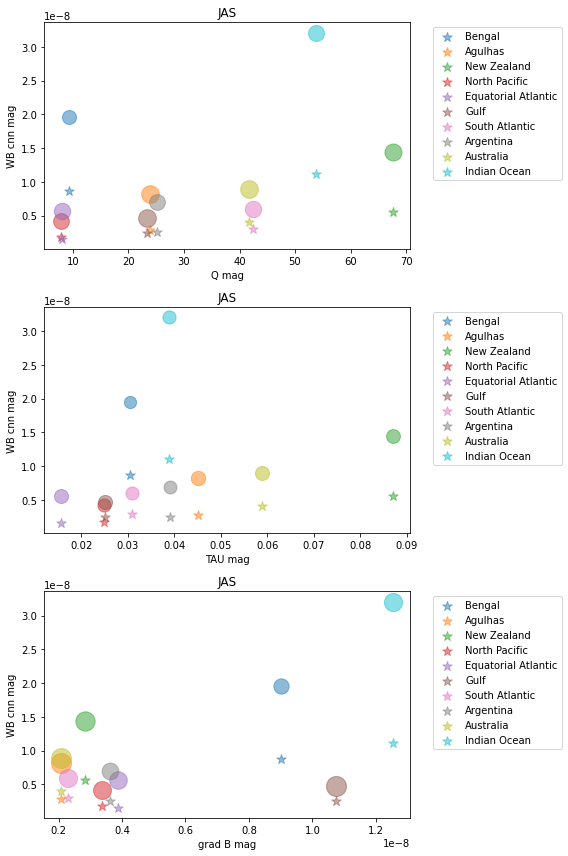

In [54]:
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(8,12))
fig.set_tight_layout(True)

ax = plt.subplot(3,1,1)
from matplotlib.pyplot import cm
cmap='tab10'
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    plt.scatter(Q_loc_mean_JAS[i_loc],WB_cnn_loc_mean_JAS[i_loc],color=c_loc,s=100+3*jacobian_loc[i_loc,0],marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(Q_loc_mean_JAS[i_loc], WB_sg_loc_mean_JAS[i_loc],color=c_loc,s=100,marker='*',alpha=0.5)
    plt.legend(label_list,bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #ax.set_yscale('log')
    #ax.set_xscale('log')
plt.ylabel('WB cnn mag')
plt.xlabel('Q mag')
plt.title('JAS')
    
ax = plt.subplot(3,1,2)
from matplotlib.pyplot import cm
cmap='tab10'
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    plt.scatter(TAU_loc_mean_JAS[i_loc],WB_cnn_loc_mean_JAS[i_loc],color=c_loc,s=100+3*jacobian_loc[i_loc,1],marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(TAU_loc_mean_JAS[i_loc],WB_sg_loc_mean_JAS[i_loc],color=c_loc,s=100,marker='*',alpha=0.5)
    plt.legend(label_list,bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #ax.set_yscale('log')
    #ax.set_xscale('log')
plt.ylabel('WB cnn mag')
plt.xlabel('TAU mag')
plt.title('JAS')

ax = plt.subplot(3,1,3)
from matplotlib.pyplot import cm
cmap='tab10'
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    plt.scatter(grad_B_loc_mean_JAS[i_loc],WB_cnn_loc_mean_JAS[i_loc],color=c_loc,s=100+3*jacobian_loc[i_loc,2],marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(grad_B_loc_mean_JAS[i_loc],WB_sg_loc_mean_JAS[i_loc],color=c_loc,s=100,marker='*',alpha=0.5)
    plt.legend(label_list,bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #ax.set_yscale('log')
    #ax.set_xscale('log')
plt.ylabel('WB cnn mag')
plt.xlabel('grad B mag')
plt.title('JAS')

plt.savefig('./figures/cnn_7l_k5_surface_inputs_magnitude_Jacobian_JAS')


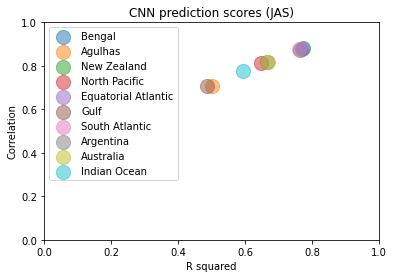

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(6,4))

from matplotlib.pyplot import cm
cmap='tab10'
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    plt.scatter(r2score_loc_JAS[i_loc],corr_loc_JAS[i_loc],color=c_loc,s=200,alpha=0.5)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.legend(label_list)
plt.xlabel('R squared')
plt.ylabel('Correlation')
plt.title('CNN prediction scores (JAS)')
plt.savefig('./figures/cnn_7l_k5_surface_inputs_R2_corr_scores_JAS')

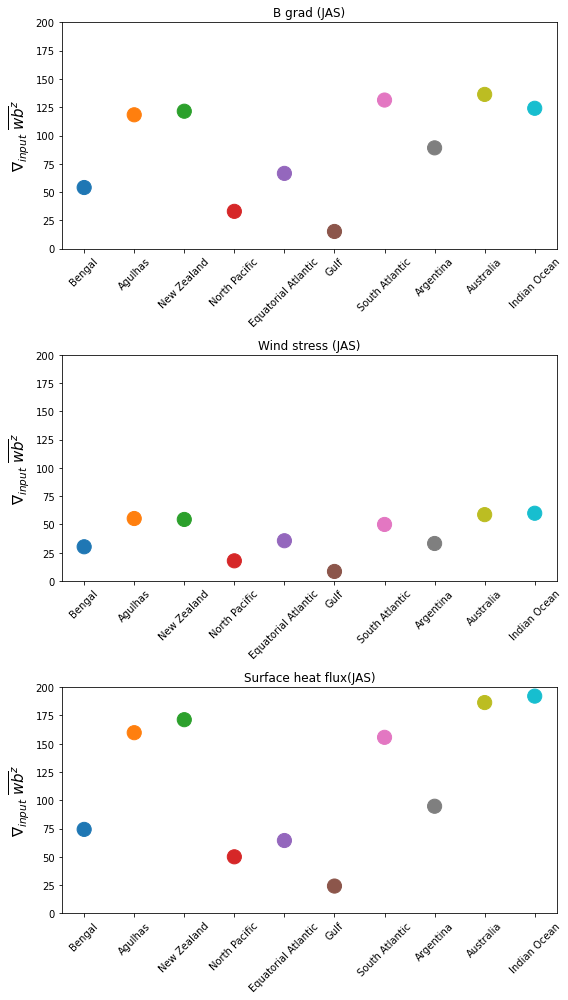

In [56]:
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(8,14))
fig.set_tight_layout(True)

ax = plt.subplot(3,1,1)
plt.scatter(np.arange(10),jacobian_loc_JAS[:,0],c=range(10),s=200,cmap='tab10')
my_xticks = label_list
plt.xticks(np.arange(10), my_xticks,rotation = 45);
plt.title('B grad (JAS)')
plt.ylim([0,200])
plt.ylabel(r'$\nabla_{input}\ \overline{wb}^z}$',fontsize=15)

ax = plt.subplot(3,1,2)
plt.scatter(np.arange(10),jacobian_loc_JAS[:,1],c=range(10),s=200,cmap='tab10')
my_xticks = label_list
plt.xticks(np.arange(10), my_xticks,rotation = 45);
plt.title('Wind stress (JAS)')
plt.ylim([0,200])
plt.ylabel(r'$\nabla_{input}\ \overline{wb}^z}$',fontsize=15)

ax = plt.subplot(3,1,3)
plt.scatter(np.arange(10),jacobian_loc_JAS[:,2],c=range(10),s=200,cmap='tab10')
my_xticks = label_list
plt.xticks(np.arange(10), my_xticks,rotation = 45);
plt.title('Surface heat flux(JAS)')
plt.ylabel(r'$\nabla_{input}\ \overline{wb}^z}$',fontsize=15)
plt.ylim([0,200])
plt.savefig('./figures/cnn_7l_k5_surface_inputs_Jacobian_JAS')

## positive fluxes

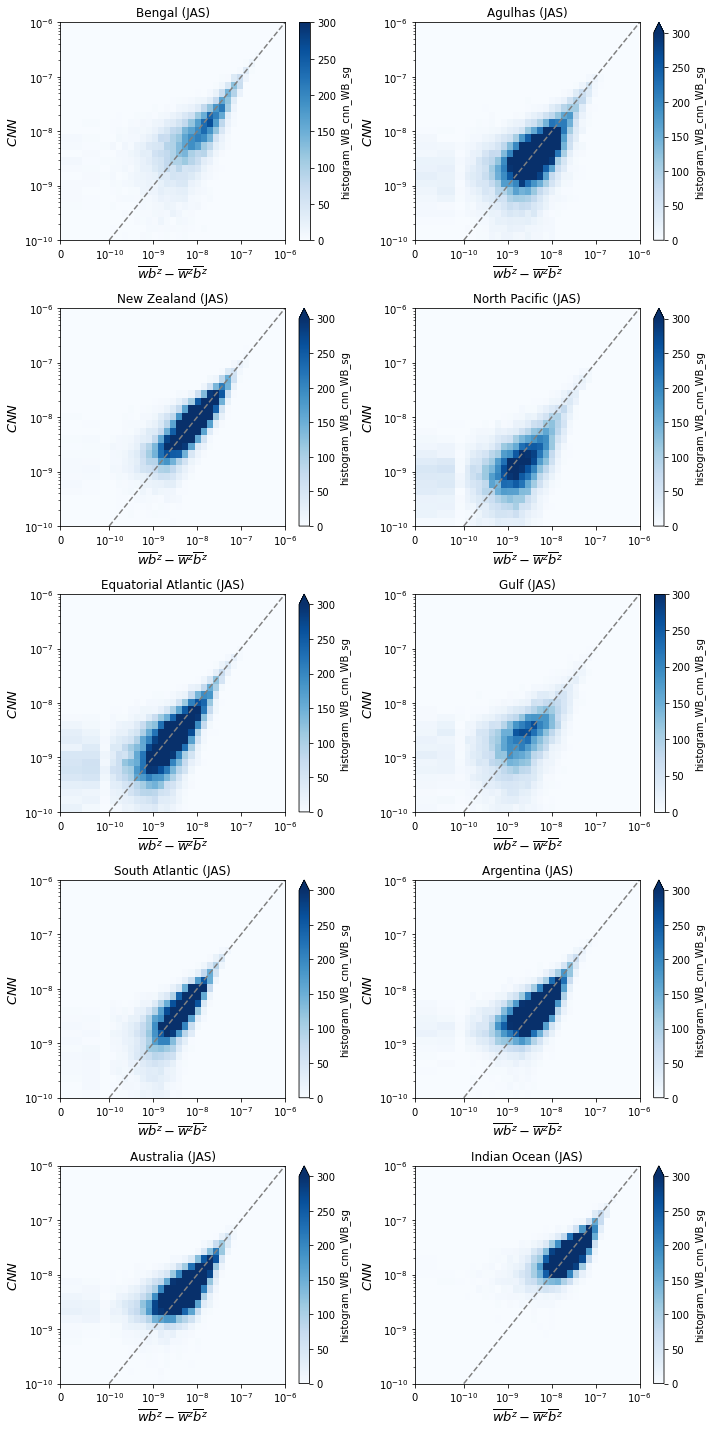

In [57]:
import matplotlib as mpl
from xhistogram.xarray import histogram as xhist

fig, axes = plt.subplots(nrows=5, ncols=2,figsize=(10,20))
fig.set_tight_layout(True)

i_plot=0

for i_loc in range(10):
    
    WB_cnn  = xr.DataArray(WB_cnn_loc_flat[i_loc,:])
    WB_cnn.name = 'WB_cnn'
    WB_sg  = xr.DataArray(WB_sg_loc_flat[i_loc,:])
    WB_sg.name = 'WB_sg'

    xhist_CNN = xhist(WB_cnn, 
      WB_sg,
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),
                                            np.logspace(-10,-6,30)))))
           ]
     ).compute()
    
    
    ax = plt.subplot(5,2,i_loc+1)
    xhist_CNN.plot(vmax=300, cmap='Blues')
    ax.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
    ax.set_xscale('symlog', linthresh=1e-10)
    ax.set_yscale('log')
    ax.set_ylim([1e-10,1e-6])
    ax.set_xlim([0,1e-6])
    ax.set_xlabel(r"$\overline{wb}^z-\overline{w}^z\overline{b}^z$", fontsize=13)
    ax.set_ylabel(r"$CNN$", 
                  fontsize=13)
    plt.title(label_list[i_loc]+' (JAS)')


plt.savefig('./figures/cnn_7l_k5_surface_inputs_all_positive_fluxes_seasonality_JAS')

## negative fluxes

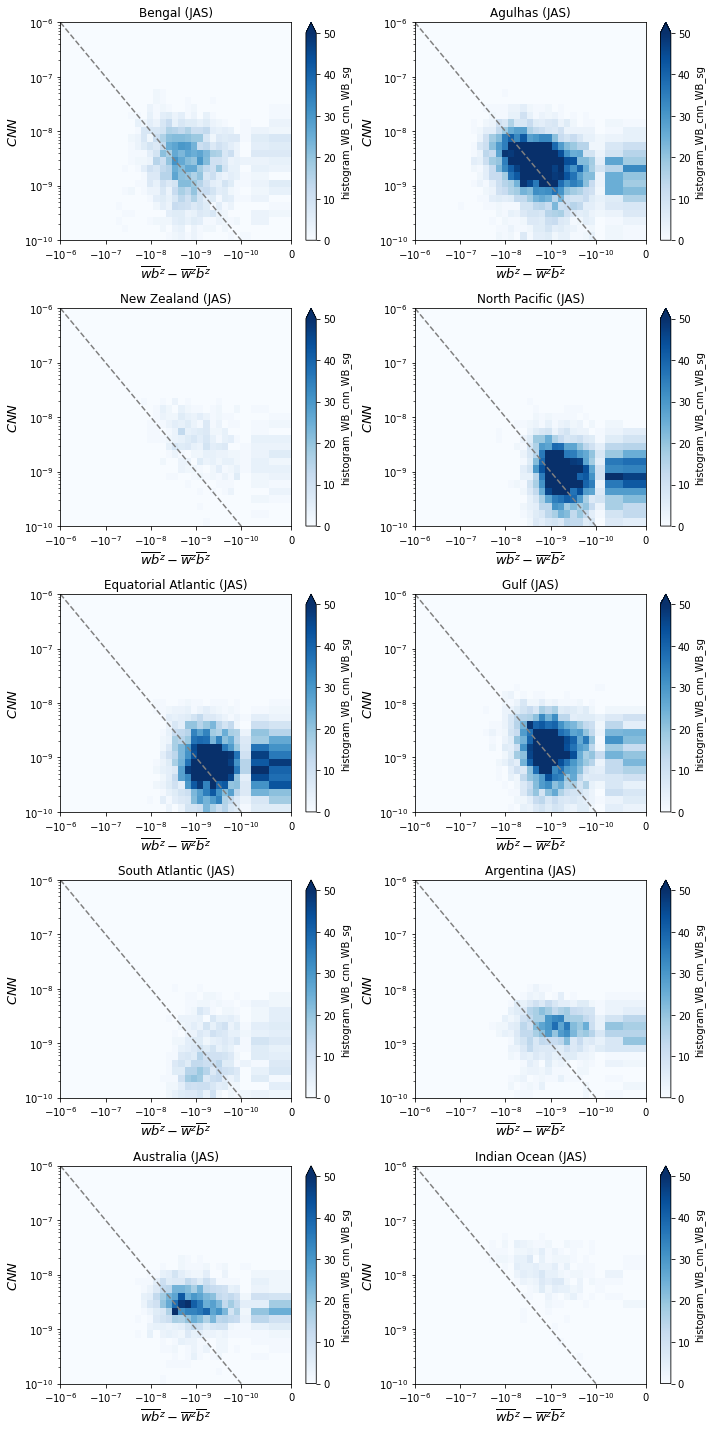

In [58]:
import matplotlib as mpl
from xhistogram.xarray import histogram as xhist

fig, axes = plt.subplots(nrows=5, ncols=2,figsize=(10,20))
fig.set_tight_layout(True)

i_plot=0

for i_loc in range(10):
    
    WB_cnn  = xr.DataArray(WB_cnn_loc_flat[i_loc,:])
    WB_cnn.name = 'WB_cnn'
    WB_sg  = xr.DataArray(WB_sg_loc_flat[i_loc,:])
    WB_sg.name = 'WB_sg'

    xhist_CNN = xhist(WB_cnn, 
      WB_sg,
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),
                                            np.logspace(-10,-6,30)))))
           ]
     ).compute()
    ax = plt.subplot(5,2,i_loc+1)
    xhist_CNN.plot(vmax=50, cmap='Blues')
    ax.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
    ax.set_xscale('symlog', linthresh=1e-10)
    ax.set_yscale('log')
    ax.set_ylim([1e-10,1e-6])
    ax.set_xlim([-1e-6,0])
    ax.set_xlabel(r"$\overline{wb}^z-\overline{w}^z\overline{b}^z$", fontsize=13)
    ax.set_ylabel(r"$CNN$", 
                  fontsize=13)
    plt.title(label_list[i_loc]+' (JAS)')


plt.savefig('./figures/cnn_7l_k5_surface_inputs_all_negative_fluxes_seasonality_JAS')

# input magnitude and sensitivity

In [59]:
# split into global winter and summer

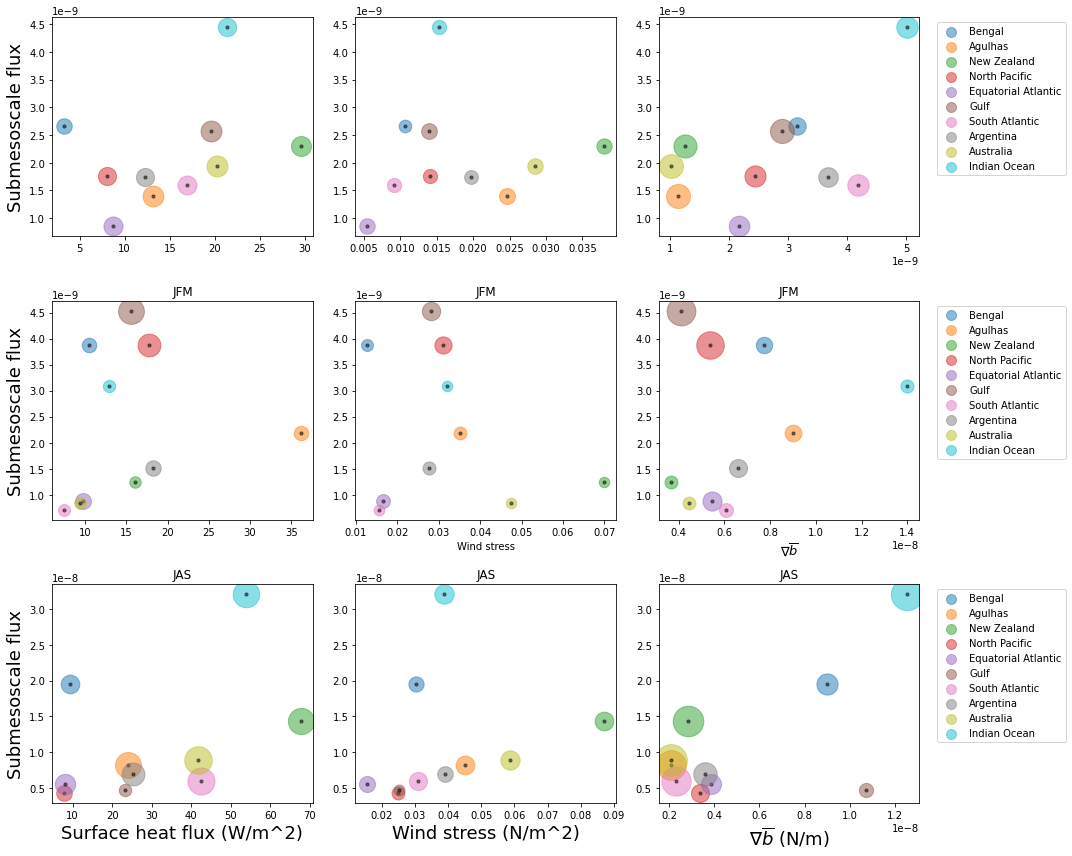

In [79]:
fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(15,12))
fig.set_tight_layout(True)

ax = plt.subplot(3,3,1)
from matplotlib.pyplot import cm
cmap='tab10'
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    plt.scatter(Q_loc_mean[i_loc],WB_cnn_loc_mean[i_loc],color=c_loc,s=80+5*jacobian_loc[i_loc,0],marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(Q_loc_mean[i_loc],WB_cnn_loc_mean[i_loc],color='k',s=10,marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(Q_loc_mean[i_loc]*np.nan, WB_sg_loc_mean[i_loc],color=c_loc,s=100,marker='o',alpha=0.5)
    #plt.legend(label_list,bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #ax.set_yscale('log')
    #ax.set_xscale('log')
    #plt.xlim([0,150])
    #plt.ylim([0,4e-8])
plt.ylabel('Submesoscale flux', fontsize=18)
#plt.xlabel('Surface heat flux')

    
ax = plt.subplot(3,3,2)
from matplotlib.pyplot import cm
cmap='tab10'
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    plt.scatter(TAU_loc_mean[i_loc],WB_cnn_loc_mean[i_loc],color=c_loc,s=80+5*jacobian_loc[i_loc,1],marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(TAU_loc_mean[i_loc],WB_cnn_loc_mean[i_loc],color='k',s=10,marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(TAU_loc_mean[i_loc]*np.nan,WB_sg_loc_mean[i_loc],color=c_loc,s=100,marker='o',alpha=0.5)
    #plt.legend(label_list,bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #ax.set_yscale('log')
    #ax.set_xscale('log')
    #plt.xlim([0,3e-1])
    #plt.ylim([0,4e-8])
#plt.ylabel('WB cnn mag')
#plt.xlabel('Wind stress')


ax = plt.subplot(3,3,3)
from matplotlib.pyplot import cm
cmap='tab10'
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    plt.scatter(grad_B_loc_mean[i_loc],WB_cnn_loc_mean[i_loc],color=c_loc,s=80+5*jacobian_loc[i_loc,2],marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(grad_B_loc_mean[i_loc],WB_cnn_loc_mean[i_loc],color='k',s=10,marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(grad_B_loc_mean[i_loc]*np.nan,WB_sg_loc_mean[i_loc],color=c_loc,s=100,marker='o',alpha=0.5)
    plt.legend(label_list,bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #ax.set_yscale('log')
    #ax.set_xscale('log')
    #plt.xlim([0,6e-8])
    #plt.ylim([0,4e-8])
#plt.ylabel('WB cnn mag')
#plt.xlabel(r"$\nabla\overline{b}$", fontsize=13)



ax = plt.subplot(3,3,4)
from matplotlib.pyplot import cm
cmap='tab10'
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    plt.scatter(Q_loc_mean_JFM[i_loc],WB_cnn_loc_mean_JFM[i_loc],color=c_loc,s=80+5*jacobian_loc_JFM[i_loc,0],marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(Q_loc_mean_JFM[i_loc],WB_cnn_loc_mean_JFM[i_loc],color='k',s=10,marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(Q_loc_mean_JFM[i_loc]*np.nan, WB_cnn_loc_mean_JFM[i_loc],color=c_loc,s=100,marker='o',alpha=0.5)
    #plt.legend(label_list,bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #ax.set_yscale('log')
    #ax.set_xscale('log')
    #plt.xlim([0,150])
    #plt.ylim([0,4e-8])
plt.ylabel('Submesoscale flux', fontsize=18)
#plt.xlabel('Surface heat flux')
plt.title('JFM')
    
ax = plt.subplot(3,3,5)
from matplotlib.pyplot import cm
cmap='tab10'
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    plt.scatter(TAU_loc_mean_JFM[i_loc],WB_cnn_loc_mean_JFM[i_loc],color=c_loc,s=80+5*jacobian_loc_JFM[i_loc,1],marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(TAU_loc_mean_JFM[i_loc],WB_cnn_loc_mean_JFM[i_loc],color='k',s=10,marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(TAU_loc_mean[i_loc]*np.nan,WB_sg_loc_mean[i_loc],color=c_loc,s=100,marker='o',alpha=0.5)
    #plt.legend(label_list,bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #ax.set_yscale('log')
    #ax.set_xscale('log')
    #plt.xlim([0,3e-1])
    #plt.ylim([0,4e-8])
#plt.ylabel('WB cnn mag')
plt.xlabel('Wind stress')
plt.title('JFM')

ax = plt.subplot(3,3,6)
from matplotlib.pyplot import cm
cmap='tab10'
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    plt.scatter(grad_B_loc_mean_JFM[i_loc],WB_cnn_loc_mean_JFM[i_loc],color=c_loc,s=80+5*jacobian_loc_JFM[i_loc,2],marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(grad_B_loc_mean_JFM[i_loc],WB_cnn_loc_mean_JFM[i_loc],color='k',s=10,marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(grad_B_loc_mean[i_loc]*np.nan,WB_sg_loc_mean[i_loc],color=c_loc,s=100,marker='o',alpha=0.5)
    plt.legend(label_list,bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #ax.set_yscale('log')
    #ax.set_xscale('log')
    #plt.xlim([0,6e-8])
    #plt.ylim([0,4e-8])
#plt.ylabel('WB cnn mag')
plt.xlabel(r"$\nabla\overline{b}$", fontsize=13)
plt.title('JFM')



ax = plt.subplot(3,3,7)
from matplotlib.pyplot import cm
cmap='tab10'
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    plt.scatter(Q_loc_mean_JAS[i_loc],WB_cnn_loc_mean_JAS[i_loc],color=c_loc,s=80+5*jacobian_loc_JAS[i_loc,0],marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(Q_loc_mean_JAS[i_loc],WB_cnn_loc_mean_JAS[i_loc],color='k',s=10,marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(Q_loc_mean[i_loc]*np.nan, WB_sg_loc_mean[i_loc],color=c_loc,s=100,marker='o',alpha=0.5)
    #plt.legend(label_list,bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #ax.set_yscale('log')
    #ax.set_xscale('log')
    #plt.xlim([0,150])
    #plt.ylim([0,4e-8])
plt.ylabel('Submesoscale flux', fontsize=18)
plt.xlabel('Surface heat flux (W/m^2)', fontsize=18)
plt.title('JAS')
    
ax = plt.subplot(3,3,8)
from matplotlib.pyplot import cm
cmap='tab10'
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    plt.scatter(TAU_loc_mean_JAS[i_loc],WB_cnn_loc_mean_JAS[i_loc],color=c_loc,s=80+5*jacobian_loc_JAS[i_loc,1],marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(TAU_loc_mean_JAS[i_loc],WB_cnn_loc_mean_JAS[i_loc],color='k',s=10,marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(TAU_loc_mean[i_loc]*np.nan,WB_sg_loc_mean[i_loc],color=c_loc,s=100,marker='o',alpha=0.5)
    #plt.legend(label_list,bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #ax.set_yscale('log')
    #ax.set_xscale('log')
    #plt.xlim([0,3e-1])
    #plt.ylim([0,4e-8])
#plt.ylabel('WB cnn mag')
plt.xlabel('Wind stress (N/m^2)', fontsize=18)
plt.title('JAS')

ax = plt.subplot(3,3,9)
from matplotlib.pyplot import cm
cmap='tab10'
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    plt.scatter(grad_B_loc_mean_JAS[i_loc],WB_cnn_loc_mean_JAS[i_loc],color=c_loc,s=80+5*jacobian_loc_JAS[i_loc,2],marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(grad_B_loc_mean_JAS[i_loc],WB_cnn_loc_mean_JAS[i_loc],color='k',s=10,marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(grad_B_loc_mean[i_loc]*np.nan,WB_sg_loc_mean[i_loc],color=c_loc,s=100,marker='o',alpha=0.5)
    plt.legend(label_list,bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #ax.set_yscale('log')
    #ax.set_xscale('log')
    #plt.xlim([0,6e-8])
    #plt.ylim([0,4e-8])
#plt.ylabel('CNN prediction', fontsize=13)
plt.xlabel(r"$\nabla\overline{b}$ (N/m)", fontsize=18)
plt.title('JAS')

plt.savefig('./figures/cnn_7l_k5_surface_inputs_mean_Jacobian')
